In [1]:
%load_ext autoreload

In [149]:
import lightning.pytorch as pl
import torch
import os
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scanpy as sc
import anndata
from matplotlib import rcParams

In [3]:
%autoreload 2
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPClassifier
from self_supervision.tester.classifier.test import eval_emb_knn
from self_supervision.tester.classifier.histogram import get_histogram
from self_supervision.data.datamodules import get_large_ood_dataloader
from self_supervision.data.ood_adata import create_ood_dataloader

In [4]:
DATA_PATH = '/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p'  # this is a shared directory in which the data is stored
MODEL_PATH = '/lustre/groups/ml01/workspace/till.richter/trained_models/'
RESULT_PATH = '/lustre/groups/ml01/workspace/till.richter/ssl_results'
ADATA_PATH = '/lustre/groups/ml01/workspace/till.richter/'
HVG = True

In [48]:
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Set the colorblind friendly palette
sns.set_palette("colorblind")
sns.set_theme(style="whitegrid")
# Get the list of colors in the palette
palette_colors = sns.color_palette("colorblind")

# Access the colors
color_supervised = palette_colors[0]  # First color
color_ssl = palette_colors[1]  # Second color
color_zeroshot = palette_colors[2]  # Third color
color_baseline = palette_colors[3]  # Forth color, ([3] looks similar to [0])
color_else1 = palette_colors[5]
color_else2 = palette_colors[6]
color_else3 = palette_colors[7]

In [49]:
# Map the model types to specific colors
color_dict = {
    'Zero-Shot\nRandom Mask': color_zeroshot,
    'Zero-Shot:\nRandom Mask': color_zeroshot,
    'Zero-Shot\nGP Mask': color_zeroshot,
    'Zero-Shot\nGP to TF': color_zeroshot,
    'Zero-Shot\nGP to GP': color_zeroshot,
    'Zero-Shot\nBYOL': color_zeroshot,
    'Zero-Shot\nBarlow Twins': color_zeroshot,
    'Supervised': color_supervised,
    'PCA': palette_colors[3],
    'Random': palette_colors[3],
    'Self-Supervised\nRandom Mask': color_ssl,
    'Self-Supervised\nGP Mask': color_ssl,
    'Self-Supervised\nGP to TF': color_ssl,
    'Self-Supervised\nGP to GP': color_ssl,
    'Self-Supervised\nBYOL': color_ssl,
    'Self-Supervised\nBarlow Twins': color_ssl
}

In [7]:
color_supervised

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

# Figure 1
Compare performance on hold out test set on CellNet

kNN classification to include PCA, scVI, Only Pretrained, Supervised, and Self-Supervised

1) Full Transcriptome

In [21]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_CellNet_knn.csv')
df = pd.read_csv(file_path)

# Drop duplicates
df_unique = df.drop_duplicates()
df_unique.reset_index(drop=True, inplace=True)

# Show the first few rows to get an overview of the data
df_unique

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.796648,0.687486,0.797259,0.796648,0.616566,0.796648,0.796648,0.629193,0.789696,0.796648,3448832.0,3448832.0
1,CN_MLP_50prun1_Only Pretrained,0.811840,0.704358,0.814228,0.811840,0.646979,0.811840,0.811840,0.654910,0.806839,0.811840,3448832.0,3448832.0
2,CN_MLP_50prun2_Only Pretrained,0.822599,0.703593,0.825211,0.822599,0.662319,0.822599,0.822599,0.660416,0.817695,0.822599,3448832.0,3448832.0
3,CN_MLP_50prun3_Only Pretrained,0.817777,0.710244,0.818301,0.817777,0.651561,0.817777,0.817777,0.657790,0.811207,0.817777,3448832.0,3448832.0
4,CN_MLP_50prun4_Only Pretrained,0.803451,0.694791,0.804528,0.803451,0.635294,0.803451,0.803451,0.644204,0.796915,0.803451,3448832.0,3448832.0
5,CN_MLP_gene_program_C8_25p_Only Pretrained,0.821322,0.712525,0.822761,0.821322,0.671336,0.821322,0.821322,0.672496,0.816017,0.821322,3448832.0,3448832.0
6,CN_MLP_gp_to_tf_Only Pretrained,0.707912,0.589827,0.707862,0.707912,0.487070,0.707912,0.707912,0.509707,0.695416,0.707912,3448832.0,3448832.0
7,CN_MLP_single_gene_program_Only Pretrained,0.703981,0.577372,0.704306,0.703981,0.490553,0.703981,0.703981,0.505185,0.691896,0.703981,3448832.0,3448832.0
8,GeneFormer,0.614441,0.399361,0.609635,0.614441,0.360945,0.614441,0.614441,0.362621,0.600808,0.614441,3448832.0,3448832.0
9,MLP_BYOL_Gaussian_0_001_v4_Only Pretrained,0.294380,0.201680,0.309656,0.294380,0.112817,0.294380,0.294380,0.122541,0.271400,0.294380,3448832.0,3448832.0


In [22]:
models_to_select = ['CN_MLP_50prun2_Only Pretrained',  # Best Run 
                    'CN_MLP_gene_program_C8_25p_Only Pretrained', 
                    'CN_MLP_gp_to_tf_Only Pretrained', 
                    'CN_MLP_single_gene_program_Only Pretrained',
                    'MLP_BYOL_Gaussian_0_001_v4_Only Pretrained',
                    'GeneFormer',
                    'No_SSL_run1_No SSL',  # Best Run
                    'PCA',
                    'Random',
                    'SSL_CN_MLP_50prun4_SSL',  # Best Run
                    'SSL_CN_MLP_gene_program_C8_25prun0_SSL',  # Best Run
                    'SSL_CN_MLP_gp_to_tfrun0_SSL',
                    'SSL_CN_MLP_single_gene_programrun0_SSL',
                    'SSL_MLP_BYOL_Gaussian_0_001run0_SSL',
                    'SSL_contrastive_MLP_bt_Gaussian_0_01run0_SSL',
                    '_Only Pretrained',
                   ]

df_subset = df_unique[df_unique['Unnamed: 0'].isin(models_to_select)]
df_subset

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
1,CN_MLP_50prun1_Only Pretrained,0.811840,0.704358,0.814228,0.811840,0.646979,0.811840,0.811840,0.654910,0.806839,0.811840,3448832.0,3448832.0
5,CN_MLP_gene_program_C8_25p_Only Pretrained,0.821322,0.712525,0.822761,0.821322,0.671336,0.821322,0.821322,0.672496,0.816017,0.821322,3448832.0,3448832.0
6,CN_MLP_gp_to_tf_Only Pretrained,0.707912,0.589827,0.707862,0.707912,0.487070,0.707912,0.707912,0.509707,0.695416,0.707912,3448832.0,3448832.0
7,CN_MLP_single_gene_program_Only Pretrained,0.703981,0.577372,0.704306,0.703981,0.490553,0.703981,0.703981,0.505185,0.691896,0.703981,3448832.0,3448832.0
8,GeneFormer,0.614441,0.399361,0.609635,0.614441,0.360945,0.614441,0.614441,0.362621,0.600808,0.614441,3448832.0,3448832.0
9,MLP_BYOL_Gaussian_0_001_v4_Only Pretrained,0.294380,0.201680,0.309656,0.294380,0.112817,0.294380,0.294380,0.122541,0.271400,0.294380,3448832.0,3448832.0
11,No_SSL_run0_No SSL,0.898384,0.838716,0.899413,0.898384,0.819925,0.898384,0.898384,0.819361,0.896806,0.898384,3448832.0,3448832.0
16,PCA,0.282261,0.090695,0.290242,0.282261,0.079138,0.282261,0.282261,0.064686,0.255513,0.282261,3448832.0,3448832.0
17,Random,0.120784,0.060220,0.191375,0.120784,0.023649,0.120784,0.120784,0.020617,0.090398,0.120784,3448832.0,3448832.0
21,SSL_CN_MLP_50prun3_SSL,0.897023,0.840632,0.898222,0.897023,0.818031,0.897023,0.897023,0.818363,0.895157,0.897023,3448832.0,3448832.0


In [26]:
custom_model_names = {
    'CN_MLP_50prun2_Only Pretrained': 'Zero-Shot\nRandom Mask',
    'CN_MLP_gene_program_C8_25p_Only Pretrained': 'Zero-Shot\nGP Mask',
    'CN_MLP_gp_to_tf_Only Pretrained': 'Zero-Shot\nGP to TF',
    'CN_MLP_single_gene_program_Only Pretrained': 'Zero-Shot\nGP to GP',
    'MLP_BYOL_Gaussian_0_001_v4_Only Pretrained': 'Zero-Shot\nBYOL',
    '_Only Pretrained': 'Zero-Shot\nBarlow Twins',
    'No_SSL_run1_No SSL': 'Supervised',
    'Random': 'Random',
    'PCA': 'PCA',
    'GeneFormer': 'GeneFormer',
    'SSL_CN_MLP_50prun4_SSL': 'Self-Supervised\nRandom Mask',
    'SSL_CN_MLP_gene_program_C8_25prun0_SSL': 'Self-Supervised\nGP Mask',
    'SSL_CN_MLP_gp_to_tfrun0_SSL': 'Self-Supervised\nGP to TF',
    'SSL_CN_MLP_single_gene_programrun0_SSL': 'Self-Supervised\nGP to GP',
    'SSL_MLP_BYOL_Gaussian_0_001run0_SSL': 'Self-Supervised\nBYOL',
    'SSL_contrastive_MLP_bt_Gaussian_0_01run0_SSL': 'Self-Supervised\nBarlow Twins',
}

df_subset['Unnamed: 0'] = df_subset['Unnamed: 0'].apply(lambda x: custom_model_names.get(x, x))
df_subset = df_subset.drop_duplicates(subset='Unnamed: 0', keep='first')

df_subset

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Color
1,Zero-Shot\nRandom Mask,0.811840,0.704358,0.814228,0.811840,0.646979,0.811840,0.811840,0.654910,0.806839,0.811840,3448832.0,3448832.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
5,Zero-Shot\nGP Mask,0.821322,0.712525,0.822761,0.821322,0.671336,0.821322,0.821322,0.672496,0.816017,0.821322,3448832.0,3448832.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
6,Zero-Shot\nGP to TF,0.707912,0.589827,0.707862,0.707912,0.487070,0.707912,0.707912,0.509707,0.695416,0.707912,3448832.0,3448832.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
7,Zero-Shot\nGP to GP,0.703981,0.577372,0.704306,0.703981,0.490553,0.703981,0.703981,0.505185,0.691896,0.703981,3448832.0,3448832.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
8,GeneFormer,0.614441,0.399361,0.609635,0.614441,0.360945,0.614441,0.614441,0.362621,0.600808,0.614441,3448832.0,3448832.0,"(0.8352941176470589, 0.3686274509803922, 0.0)"
9,Zero-Shot\nBYOL,0.294380,0.201680,0.309656,0.294380,0.112817,0.294380,0.294380,0.122541,0.271400,0.294380,3448832.0,3448832.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
11,Supervised,0.898384,0.838716,0.899413,0.898384,0.819925,0.898384,0.898384,0.819361,0.896806,0.898384,3448832.0,3448832.0,"(0.00392156862745098, 0.45098039215686275, 0.6..."
16,PCA,0.282261,0.090695,0.290242,0.282261,0.079138,0.282261,0.282261,0.064686,0.255513,0.282261,3448832.0,3448832.0,"(0.8352941176470589, 0.3686274509803922, 0.0)"
17,Random,0.120784,0.060220,0.191375,0.120784,0.023649,0.120784,0.120784,0.020617,0.090398,0.120784,3448832.0,3448832.0,"(0.8352941176470589, 0.3686274509803922, 0.0)"
21,Self-Supervised\nRandom Mask,0.897023,0.840632,0.898222,0.897023,0.818031,0.897023,0.897023,0.818363,0.895157,0.897023,3448832.0,3448832.0,"(0.8705882352941177, 0.5607843137254902, 0.019..."


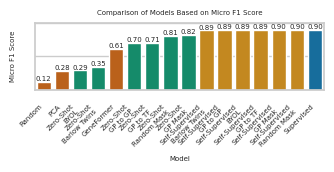

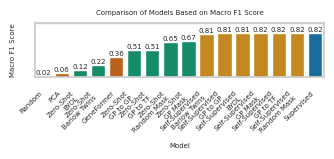

In [29]:

# Map the model types to specific colors
color_dict = {
    'Zero-Shot\nRandom Mask': color_zeroshot,
    'Zero-Shot:\nRandom Mask': color_zeroshot,
    'Zero-Shot\nGP Mask': color_zeroshot,
    'Zero-Shot\nGP to TF': color_zeroshot,
    'Zero-Shot\nGP to GP': color_zeroshot,
    'Zero-Shot\nBYOL': color_zeroshot,
    'Zero-Shot\nBarlow Twins': color_zeroshot,
    'Supervised': color_supervised,
    'PCA': palette_colors[3],
    'GeneFormer': palette_colors[3],
    'Random': palette_colors[3],
    'Self-Supervised\nRandom Mask': color_ssl,
    'Self-Supervised\nGP Mask': color_ssl,
    'Self-Supervised\nGP to TF': color_ssl,
    'Self-Supervised\nGP to GP': color_ssl,
    'Self-Supervised\nBYOL': color_ssl,
    'Self-Supervised\nBarlow Twins': color_ssl
}

tick_font_size = 5  # For tick labels

df_subset['Color'] = df_subset['Unnamed: 0'].map(color_dict)
assert not df_subset['Color'].isnull().any(), "Some model types don't have a color assigned in the color_dict."

# Sort the dataframe by 'f1-score: accuracy' for the barplot
df_subset_sorted_micro = df_subset.sort_values('f1-score: accuracy')

# Sort the dataframe by 'f1-score: macro avg' for the barplot
df_subset_sorted_macro = df_subset.sort_values('f1-score: macro avg')


# Adjusted function to annotate bars
def annotate_bars(ax, data, score_column):
    max_height = data[score_column].max()
    for p in ax.patches:
        annotation = f"{p.get_height():.2f}"
        # weight = 'bold' if p.get_height() == max_height else 'normal'
        weight='normal'
        ax.annotate(annotation, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=font['size'], weight=weight)

# Micro F1 Score plot
plt.figure(figsize=(3.5, 1.75))
ax1 = sns.barplot(x='Unnamed: 0', y='f1-score: accuracy', data=df_subset_sorted_micro,
                  palette=df_subset_sorted_micro['Color'].tolist())
ax1.set_ylim(0.0, 1.0)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=tick_font_size)
ax1.set_yticklabels([])
ax1.set_xlabel('Model', fontsize=font['size'])
ax1.set_ylabel('Micro F1 Score', fontsize=font['size'])
annotate_bars(ax1, df_subset_sorted_micro, 'f1-score: accuracy')
plt.tight_layout()
ax1.set_title('Comparison of Models Based on Micro F1 Score', fontsize=font['size'])
plt.savefig(RESULT_PATH + "/classification/Model_Comparison_Micro_F1_incl_GeneFormer.svg", bbox_inches='tight')
plt.show()

# Macro F1 Score plot
plt.figure(figsize=(3.5, 1.75))
ax2 = sns.barplot(x='Unnamed: 0', y='f1-score: macro avg', data=df_subset_sorted_macro,
                  palette=df_subset_sorted_macro['Color'].tolist())
ax2.set_ylim(0.0, 1.0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=tick_font_size)
ax2.set_yticklabels([])
ax2.set_xlabel('Model', fontsize=font['size'])
ax2.set_ylabel('Macro F1 Score', fontsize=font['size'])
ax2.set_title('Comparison of Models Based on Macro F1 Score', fontsize=font['size'])
annotate_bars(ax2, df_subset_sorted_macro, 'f1-score: macro avg')
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/Model_Comparison_Macro_F1_incl_GeneFormer.svg", bbox_inches='tight')

plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your data processing code here...

# Setting the style for the plots
sns.set_theme()
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}  # This will be for titles and labels
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # For tick labels

def annotate_bars(ax):
    for i, p in enumerate(ax.patches):
        vertical_offset = p.get_height() * 0.01  # Small vertical offset
        font_weight = 'bold' if i == len(ax.patches) - 1 else 'normal'
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height() + vertical_offset),
                    ha='center', va='baseline',
                    **font, weight=font_weight)  # Using the font dictionary here

# Plot for Micro F1 Score
plt.figure(figsize=(5, 2))
ax1 = sns.barplot(x='Unnamed: 0', y='f1-score: accuracy', data=df_subset.sort_values('f1-score: accuracy'))
ax1.set_ylim(0.0, 1.0)

# Set the font for the tick labels and rotate them for better visibility
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', **tick_font)
plt.setp(ax1.get_xticklabels(), va="top", ha="right")  # Adjust the vertical alignment

ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Micro F1 Score', fontdict=font)
ax1.set_title('Comparison of Models Based on Micro F1 Score', fontdict=font)

# Annotate bars
annotate_bars(ax1)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/Model_Comparison_Micro_F1.svg", bbox_inches='tight')
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(5, 2))
ax2 = sns.barplot(x='Unnamed: 0', y='f1-score: macro avg', data=df_subset.sort_values('f1-score: macro avg'))
ax2.set_ylim(0.0, 1.0)

# Set the font for the tick labels and rotate them for better visibility
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', **tick_font)
plt.setp(ax2.get_xticklabels(), va="top", ha="right")  # Adjust the vertical alignment

ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('Macro F1 Score', fontdict=font)
ax2.set_title('Comparison of Models Based on Macro F1 Score', fontdict=font)

# Annotate bars
annotate_bars(ax2)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/Model_Comparison_Macro_F1.svg", bbox_inches='tight')
plt.show()


In [126]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_CellNet_knn.csv')
df = pd.read_csv(file_path)

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.796648,0.687486,0.797259,0.796648,0.616566,0.796648,0.796648,0.629193,0.789696,0.796648,3448832.0,3448832.0
1,CN_MLP_50prun1_Only Pretrained,0.811840,0.704358,0.814228,0.811840,0.646979,0.811840,0.811840,0.654910,0.806839,0.811840,3448832.0,3448832.0
2,CN_MLP_50prun2_Only Pretrained,0.822599,0.703593,0.825211,0.822599,0.662319,0.822599,0.822599,0.660416,0.817695,0.822599,3448832.0,3448832.0
3,CN_MLP_50prun3_Only Pretrained,0.817777,0.710244,0.818301,0.817777,0.651561,0.817777,0.817777,0.657790,0.811207,0.817777,3448832.0,3448832.0
4,CN_MLP_50prun4_Only Pretrained,0.803451,0.694791,0.804528,0.803451,0.635294,0.803451,0.803451,0.644204,0.796915,0.803451,3448832.0,3448832.0
5,CN_MLP_gene_program_C8_25p_Only Pretrained,0.821322,0.712525,0.822761,0.821322,0.671336,0.821322,0.821322,0.672496,0.816017,0.821322,3448832.0,3448832.0
6,CN_MLP_gp_to_tf_Only Pretrained,0.707912,0.589827,0.707862,0.707912,0.487070,0.707912,0.707912,0.509707,0.695416,0.707912,3448832.0,3448832.0
7,CN_MLP_single_gene_program_Only Pretrained,0.703981,0.577372,0.704306,0.703981,0.490553,0.703981,0.703981,0.505185,0.691896,0.703981,3448832.0,3448832.0
8,MLP_BYOL_Gaussian_0_001_v4_Only Pretrained,0.294380,0.201680,0.309656,0.294380,0.112817,0.294380,0.294380,0.122541,0.271400,0.294380,3448832.0,3448832.0
9,No_SSL_HVG_2000_run0_No SSL,0.857961,0.794260,0.858660,0.857961,0.770764,0.857961,0.857961,0.769494,0.854974,0.857961,3448832.0,3448832.0


In [127]:
models_to_select = ['CN_MLP_50p_Only Pretrained', 
                    'CN_MLP_50prun1_Only Pretrained', 
                    'CN_MLP_50prun2_Only Pretrained', 
                    'CN_MLP_50prun3_Only Pretrained',
                    'CN_MLP_50prun4_Only Pretrained',
                    'No_SSL_run0_No SSL',
                    'No_SSL_run1_No SSL',
                    'No_SSL_run2_No SSL',
                    'No_SSL_run3_No SSL',
                    'No_SSL_run4_No SSL',
                    'SSL_CN_MLP_50prun0_SSL',
                    'SSL_CN_MLP_50prun1_SSL',
                    'SSL_CN_MLP_50prun2_SSL',
                    'SSL_CN_MLP_50prun3_SSL',
                    'SSL_CN_MLP_50prun4_SSL',
                   ]

df_subset = df[df['Unnamed: 0'].isin(models_to_select)]
df_subset

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.796648,0.687486,0.797259,0.796648,0.616566,0.796648,0.796648,0.629193,0.789696,0.796648,3448832.0,3448832.0
1,CN_MLP_50prun1_Only Pretrained,0.811840,0.704358,0.814228,0.811840,0.646979,0.811840,0.811840,0.654910,0.806839,0.811840,3448832.0,3448832.0
2,CN_MLP_50prun2_Only Pretrained,0.822599,0.703593,0.825211,0.822599,0.662319,0.822599,0.822599,0.660416,0.817695,0.822599,3448832.0,3448832.0
3,CN_MLP_50prun3_Only Pretrained,0.817777,0.710244,0.818301,0.817777,0.651561,0.817777,0.817777,0.657790,0.811207,0.817777,3448832.0,3448832.0
4,CN_MLP_50prun4_Only Pretrained,0.803451,0.694791,0.804528,0.803451,0.635294,0.803451,0.803451,0.644204,0.796915,0.803451,3448832.0,3448832.0
10,No_SSL_run4_No SSL,0.901287,0.838596,0.902322,0.901287,0.819411,0.901287,0.901287,0.818589,0.899525,0.901287,3448832.0,3448832.0
11,No_SSL_run1_No SSL,0.903513,0.842965,0.904033,0.903513,0.824820,0.903513,0.903513,0.824566,0.901714,0.903513,3448832.0,3448832.0
12,No_SSL_run2_No SSL,0.901581,0.840057,0.902384,0.901581,0.820372,0.901581,0.901581,0.820451,0.899796,0.901581,3448832.0,3448832.0
13,No_SSL_run3_No SSL,0.898550,0.841577,0.898791,0.898550,0.819712,0.898550,0.898550,0.820579,0.896647,0.898550,3448832.0,3448832.0
14,No_SSL_run0_No SSL,0.898384,0.838716,0.899413,0.898384,0.819925,0.898384,0.898384,0.819361,0.896806,0.898384,3448832.0,3448832.0


In [128]:
# Extract the model name from the 'Unnamed: 0' column (assuming it's the first part of the string before the '_')
df_subset['Model'] = df_subset['Unnamed: 0'].str.extract(r'(.*?)_run')

# Ensure that the f1-score columns are of float type
df_subset['f1-score: accuracy'] = df_subset['f1-score: accuracy'].astype(float)
df_subset['f1-score: macro avg'] = df_subset['f1-score: macro avg'].astype(float)

df_subset

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Model
0,CN_MLP_50p_Only Pretrained,0.796648,0.687486,0.797259,0.796648,0.616566,0.796648,0.796648,0.629193,0.789696,0.796648,3448832.0,3448832.0,NaN
1,CN_MLP_50prun1_Only Pretrained,0.811840,0.704358,0.814228,0.811840,0.646979,0.811840,0.811840,0.654910,0.806839,0.811840,3448832.0,3448832.0,NaN
2,CN_MLP_50prun2_Only Pretrained,0.822599,0.703593,0.825211,0.822599,0.662319,0.822599,0.822599,0.660416,0.817695,0.822599,3448832.0,3448832.0,NaN
3,CN_MLP_50prun3_Only Pretrained,0.817777,0.710244,0.818301,0.817777,0.651561,0.817777,0.817777,0.657790,0.811207,0.817777,3448832.0,3448832.0,NaN
4,CN_MLP_50prun4_Only Pretrained,0.803451,0.694791,0.804528,0.803451,0.635294,0.803451,0.803451,0.644204,0.796915,0.803451,3448832.0,3448832.0,NaN
10,No_SSL_run4_No SSL,0.901287,0.838596,0.902322,0.901287,0.819411,0.901287,0.901287,0.818589,0.899525,0.901287,3448832.0,3448832.0,No_SSL
11,No_SSL_run1_No SSL,0.903513,0.842965,0.904033,0.903513,0.824820,0.903513,0.903513,0.824566,0.901714,0.903513,3448832.0,3448832.0,No_SSL
12,No_SSL_run2_No SSL,0.901581,0.840057,0.902384,0.901581,0.820372,0.901581,0.901581,0.820451,0.899796,0.901581,3448832.0,3448832.0,No_SSL
13,No_SSL_run3_No SSL,0.898550,0.841577,0.898791,0.898550,0.819712,0.898550,0.898550,0.820579,0.896647,0.898550,3448832.0,3448832.0,No_SSL
14,No_SSL_run0_No SSL,0.898384,0.838716,0.899413,0.898384,0.819925,0.898384,0.898384,0.819361,0.896806,0.898384,3448832.0,3448832.0,No_SSL


In [129]:

def extract_model_type(row):
    if 'SSL_CN_MLP' in row['Unnamed: 0']:
        return 'Self-Supervised\nRandom Mask'
    elif 'CN_MLP' in row['Unnamed: 0']:
        return 'Zero-Shot\nRandom Mask'
    elif 'No_SSL' in row['Unnamed: 0']:
        return 'Supervised'
    else:
        return 'Unknown'

# Apply the function to the dataframe
df_subset['Model'] = df_subset.apply(extract_model_type, axis=1)
df_subset

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Model
0,CN_MLP_50p_Only Pretrained,0.796648,0.687486,0.797259,0.796648,0.616566,0.796648,0.796648,0.629193,0.789696,0.796648,3448832.0,3448832.0,Zero-Shot\nRandom Mask
1,CN_MLP_50prun1_Only Pretrained,0.811840,0.704358,0.814228,0.811840,0.646979,0.811840,0.811840,0.654910,0.806839,0.811840,3448832.0,3448832.0,Zero-Shot\nRandom Mask
2,CN_MLP_50prun2_Only Pretrained,0.822599,0.703593,0.825211,0.822599,0.662319,0.822599,0.822599,0.660416,0.817695,0.822599,3448832.0,3448832.0,Zero-Shot\nRandom Mask
3,CN_MLP_50prun3_Only Pretrained,0.817777,0.710244,0.818301,0.817777,0.651561,0.817777,0.817777,0.657790,0.811207,0.817777,3448832.0,3448832.0,Zero-Shot\nRandom Mask
4,CN_MLP_50prun4_Only Pretrained,0.803451,0.694791,0.804528,0.803451,0.635294,0.803451,0.803451,0.644204,0.796915,0.803451,3448832.0,3448832.0,Zero-Shot\nRandom Mask
10,No_SSL_run4_No SSL,0.901287,0.838596,0.902322,0.901287,0.819411,0.901287,0.901287,0.818589,0.899525,0.901287,3448832.0,3448832.0,Supervised
11,No_SSL_run1_No SSL,0.903513,0.842965,0.904033,0.903513,0.824820,0.903513,0.903513,0.824566,0.901714,0.903513,3448832.0,3448832.0,Supervised
12,No_SSL_run2_No SSL,0.901581,0.840057,0.902384,0.901581,0.820372,0.901581,0.901581,0.820451,0.899796,0.901581,3448832.0,3448832.0,Supervised
13,No_SSL_run3_No SSL,0.898550,0.841577,0.898791,0.898550,0.819712,0.898550,0.898550,0.820579,0.896647,0.898550,3448832.0,3448832.0,Supervised
14,No_SSL_run0_No SSL,0.898384,0.838716,0.899413,0.898384,0.819925,0.898384,0.898384,0.819361,0.896806,0.898384,3448832.0,3448832.0,Supervised


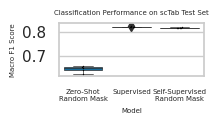

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

############################
# Suspected bug in seaborn #
############################

# Plot here with unchanged y-axis, save without y-axis and manually add it in figma

# Setting the style for the plots
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'size': 5}

# Debugging: Print median values before plotting
# print(df_subset.groupby('Model')['f1-score: macro avg'].median())

# Plot for Macro F1 Score with individual points
plt.figure(figsize=(2.3, 1.3))
ax = sns.boxplot(x='Model', y='f1-score: macro avg', data=df_subset, linewidth=0.5)
sns.swarmplot(x='Model', y='f1-score: macro avg', data=df_subset, color='black', size=1)

# Set the font for the tick labels and axis labels
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
# ax.set_yticklabels([f"{x:.2f}" for x in ax.get_yticks()], **tick_font)

# Set the font for the axis labels and title
ax.set_xlabel('Model', **font)
ax.set_ylabel('Macro F1 Score', **font)
ax.set_title('Classification Performance on scTab Test Set', **font)

plt.tight_layout()
plt.show()


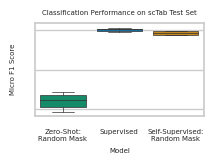

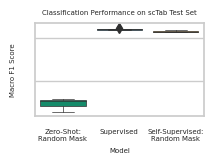

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_subset and color_dict are already defined
# Map the 'Model' column to colors
df_subset['Color'] = df_subset['Model'].map(color_dict)
# Function to categorize models
def extract_model_type(row):
    if 'Only Pretrained' in row['Unnamed: 0']:
        return 'Zero-Shot:\nRandom Mask'
    elif 'No SSL' in row['Unnamed: 0']:
        return 'Supervised'
    elif 'SSL_CN' in row['Unnamed: 0']:
        return 'Self-Supervised:\nRandom Mask'
    else:
        return 'Error'

# Apply the function to the dataframe
df_subset['Model'] = df_subset.apply(extract_model_type, axis=1)

# Ensure that the f1-score columns are of float type
df_subset['f1-score: accuracy'] = df_subset['f1-score: accuracy'].astype(float)
df_subset['f1-score: macro avg'] = df_subset['f1-score: macro avg'].astype(float)

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}

# Plot for Micro F1 Score
plt.figure(figsize=(2.3, 1.8))
ax1 = sns.boxplot(x='Model', y='f1-score: accuracy', data=df_subset, linewidth=0.5, palette=df_subset['Color'].unique().tolist())
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels([])
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Micro F1 Score', fontdict=font)
ax1.set_title('Classification Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/Model_Comparison_Micro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(2.3, 1.8))
ax2 = sns.boxplot(x='Model', y='f1-score: macro avg', data=df_subset, linewidth=0.5, palette=df_subset['Color'].unique().tolist())
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels([])
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('Macro F1 Score', fontdict=font)
ax2.set_title('Classification Performance on scTab Test Set', fontdict=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/Model_Comparison_Macro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()


# Figure 2

OOD task, where supervised learning may come to its limits

Novel, unseen dataset

**Dissection: Tail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC**

- 56,367 cells
- 10x 3' v3
- hippocampal formation
- astrocyte (3761), central nervous system macrophage (1782), endothelial cell (174), ependymal cell (111), ~~fibroblast (86)~~, leukocyte (36), neuron (36588), oligodendrocyte (11875), oligodendrocyte precursor cell (1896), pericyte (39), vascular associated smooth muscle cell (19)

In [9]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_HiT_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.993142,0.424441,0.994168,0.993142,0.407992,0.993142,0.993142,0.412011,0.993522,0.993142,56281.0,56281.0
3,CN_MLP_50prun1_Only Pretrained,0.997815,0.394518,0.998469,0.997815,0.363018,0.997815,0.997815,0.366438,0.998034,0.997815,56281.0,56281.0
6,CN_MLP_50prun2_Only Pretrained,0.995896,0.362867,0.996664,0.995896,0.357005,0.995896,0.995896,0.358695,0.996246,0.995896,56281.0,56281.0
9,CN_MLP_50prun3_Only Pretrained,0.998738,0.615198,0.999010,0.998738,0.590554,0.998738,0.998738,0.596699,0.998837,0.998738,56281.0,56281.0
12,CN_MLP_50prun4_Only Pretrained,0.998667,0.421375,0.999062,0.998667,0.404475,0.998667,0.998667,0.408075,0.998822,0.998667,56281.0,56281.0
15,No_SSL_run0_HLCA_No SSL,0.935236,0.135320,0.952957,0.935236,0.125819,0.935236,0.935236,0.127759,0.942831,0.935236,56281.0,56281.0
63,No_SSL_run0_No SSL,0.000284,0.037736,0.003731,0.000284,0.007139,0.000284,0.000284,0.010651,0.000444,0.000284,56281.0,56281.0
64,No_SSL_run1_No SSL,0.999574,0.900971,0.999611,0.999574,0.908165,0.999574,0.999574,0.904490,0.999592,0.999574,56281.0,56281.0
67,No_SSL_run2_No SSL,0.999769,0.992084,0.999770,0.999769,0.999200,0.999769,0.999769,0.995559,0.999769,0.999769,56281.0,56281.0
70,No_SSL_run3_No SSL,0.999627,0.831033,0.999663,0.999627,0.828643,0.999627,0.999627,0.829766,0.999644,0.999627,56281.0,56281.0


In [13]:
# Assuming df is your dataframe after filtering to only include the desired runs

def extract_model_type(row):
    if 'Only Pretrained' in row['Unnamed: 0']:
        return 'Zero-Shot\nRandom Mask'
    elif 'No SSL' in row['Unnamed: 0']:
        return 'Supervised'
    elif 'SSL_CN' in row['Unnamed: 0']:
        return 'Self-Supervised\nRandom Mask'
    elif 'Random' in row['Unnamed: 0']:
        return 'Random'
    else:
        return 'Error'

# Apply the function to the dataframe
df['Model'] = df.apply(extract_model_type, axis=1)

# Filter outliers
df = df[~df['Unnamed: 0'].isin(['No_SSL_run0_No SSL', 'No_SSL_run4_No SSL', 'SSL_CN_MLP_50prun0_HLCA_SSL', 'No_SSL_run0_HLCA_No SSL', 'SSL_CN_MLP_50prun1_SSL', 'SSL_CN_MLP_50prun2_SSL', 'CN_MLP_50prun1_Only Pretrained', 'CN_MLP_50prun2_Only Pretrained'])]

# Ensure that the f1-score columns are of float type
df['f1-score: accuracy'] = df['f1-score: accuracy'].astype(float)
df['f1-score: macro avg'] = df['f1-score: macro avg'].astype(float)
# Map the 'Model' column to colors
# df['Color'] = df['Model'].map(color_dict)
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Model
0,CN_MLP_50p_Only Pretrained,0.993142,0.424441,0.994168,0.993142,0.407992,0.993142,0.993142,0.412011,0.993522,0.993142,56281.0,56281.0,Zero-Shot\nRandom Mask
9,CN_MLP_50prun3_Only Pretrained,0.998738,0.615198,0.999010,0.998738,0.590554,0.998738,0.998738,0.596699,0.998837,0.998738,56281.0,56281.0,Zero-Shot\nRandom Mask
12,CN_MLP_50prun4_Only Pretrained,0.998667,0.421375,0.999062,0.998667,0.404475,0.998667,0.998667,0.408075,0.998822,0.998667,56281.0,56281.0,Zero-Shot\nRandom Mask
64,No_SSL_run1_No SSL,0.999574,0.900971,0.999611,0.999574,0.908165,0.999574,0.999574,0.904490,0.999592,0.999574,56281.0,56281.0,Supervised
67,No_SSL_run2_No SSL,0.999769,0.992084,0.999770,0.999769,0.999200,0.999769,0.999769,0.995559,0.999769,0.999769,56281.0,56281.0,Supervised
70,No_SSL_run3_No SSL,0.999627,0.831033,0.999663,0.999627,0.828643,0.999627,0.999627,0.829766,0.999644,0.999627,56281.0,56281.0,Supervised
74,Random,0.740925,0.039358,0.854921,0.740925,0.021562,0.740925,0.740925,0.026066,0.771114,0.740925,56281.0,56281.0,Random
170,SSL_CN_MLP_50prun0_SSL,0.999769,0.999855,0.999769,0.999769,0.999802,0.999769,0.999769,0.999829,0.999769,0.999769,56281.0,56281.0,Self-Supervised\nRandom Mask
179,SSL_CN_MLP_50prun3_SSL,0.999769,0.999774,0.999769,0.999769,0.999806,0.999769,0.999769,0.999790,0.999769,0.999769,56281.0,56281.0,Self-Supervised\nRandom Mask
182,SSL_CN_MLP_50prun4_SSL,0.999716,0.903578,0.999735,0.999716,0.908333,0.999716,0.999716,0.905895,0.999725,0.999716,56281.0,56281.0,Self-Supervised\nRandom Mask


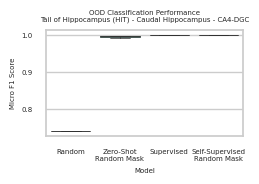

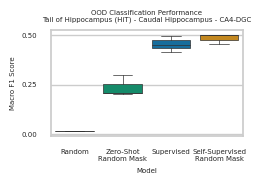

In [14]:
# Manually set the colors for each model type in the order you specified
model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Plot for Micro F1 Score
plt.figure(figsize=(2.7, 2))
ax1 = sns.boxplot(x='Model', y='f1-score: accuracy', data=df.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Micro F1 Score', fontdict=font)
ax1.set_title('OOD Classification Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_HiT_Micro_F1_Boxplot.svg", bbox_inches='tight')
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(2.7, 2))
ax2 = sns.boxplot(x='Model', y='f1-score: macro avg', data=df.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors)
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('Macro F1 Score', fontdict=font)
ax2.set_title('OOD Classification Performance\nTail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC', fontdict=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_HiT_Macro_F1_Boxplot.svg", bbox_inches='tight')
plt.show()

**All non-neuronal cells**

- 888,263 cells
- 10x 3' v3
- Bergmann glial cell (8041), astrocyte (155025), central nervous system macrophage (91383), ~~choroid plexus epithelial cell (7689)~~, endothelial cell (5165), ependymal cell (5882), ~~fibroblast (9156)~~, oligodendrocyte (494966), oligodendrocyte precursor cell (105734), pericyte (3693), vascular associated smooth muscle cell (1074)

In [45]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_nn_knn.csv')
df = pd.read_csv(file_path)
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.994172,0.121142,0.997695,0.994172,0.113036,0.994172,0.994172,0.115399,0.995772,0.994172,871418.0,871418.0
96,CN_MLP_50prun1_Only Pretrained,0.992357,0.098901,0.997487,0.992357,0.092442,0.992357,0.992357,0.093995,0.994716,0.992357,871418.0,871418.0
112,CN_MLP_50prun2_Only Pretrained,0.993871,0.101470,0.997504,0.993871,0.097361,0.993871,0.993871,0.098768,0.995606,0.993871,871418.0,871418.0
114,CN_MLP_50prun3_Only Pretrained,0.996000,0.158608,0.997993,0.996000,0.150998,0.996000,0.996000,0.153484,0.996899,0.996000,871418.0,871418.0
116,CN_MLP_50prun4_Only Pretrained,0.994688,0.125916,0.997251,0.994688,0.117897,0.994688,0.994688,0.120010,0.995796,0.994688,871418.0,871418.0
118,No_SSL_run0_No SSL,0.000199,0.013889,0.005927,0.000199,0.000465,0.000199,0.000199,0.000900,0.000384,0.000199,871418.0,871418.0
214,No_SSL_run1_No SSL,0.999373,0.345114,0.999804,0.999373,0.344603,0.999373,0.999373,0.344858,0.999588,0.999373,871418.0,871418.0
230,No_SSL_run2_No SSL,0.999280,0.345042,0.999721,0.999280,0.343891,0.999280,0.999280,0.344453,0.999500,0.999280,871418.0,871418.0
246,No_SSL_run3_No SSL,0.999256,0.298722,0.999706,0.999256,0.297777,0.999256,0.999256,0.298242,0.999481,0.999256,871418.0,871418.0
262,No_SSL_run4_No SSL,0.000296,0.013952,0.005541,0.000296,0.000746,0.000296,0.000296,0.001415,0.000562,0.000296,871418.0,871418.0


In [46]:
def extract_model_type(row):
    if 'Only Pretrained' in row['Unnamed: 0']:
        return 'Zero-Shot\nRandom Mask'
    elif 'No SSL' in row['Unnamed: 0']:
        return 'Supervised'
    elif 'SSL_CN' in row['Unnamed: 0']:
        return 'Self-Supervised\nRandom Mask'
    elif 'Random' in row['Unnamed: 0']:
        return 'Random'
    else:
        return 'Error'

# Apply the function to the dataframe
df['Model'] = df.apply(extract_model_type, axis=1)

# Filter outliers
df = df[~df['Unnamed: 0'].isin(['No_SSL_run0_No SSL', 'No_SSL_run4_No SSL', 'SSL_CN_MLP_50prun1_SSL', 'SSL_CN_MLP_50prun2_SSL', 'CN_MLP_50prun1_Only Pretrained', 'CN_MLP_50prun2_Only Pretrained'])]

# Ensure that the f1-score columns are of float type
df['f1-score: accuracy'] = df['f1-score: accuracy'].astype(float)
df['f1-score: macro avg'] = df['f1-score: macro avg'].astype(float)

# Map the 'Model' column to colors
df['Color'] = df['Model'].map(color_dict)
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Model,Color
0,CN_MLP_50p_Only Pretrained,0.994172,0.121142,0.997695,0.994172,0.113036,0.994172,0.994172,0.115399,0.995772,0.994172,871418.0,871418.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
114,CN_MLP_50prun3_Only Pretrained,0.996000,0.158608,0.997993,0.996000,0.150998,0.996000,0.996000,0.153484,0.996899,0.996000,871418.0,871418.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
116,CN_MLP_50prun4_Only Pretrained,0.994688,0.125916,0.997251,0.994688,0.117897,0.994688,0.994688,0.120010,0.995796,0.994688,871418.0,871418.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
214,No_SSL_run1_No SSL,0.999373,0.345114,0.999804,0.999373,0.344603,0.999373,0.999373,0.344858,0.999588,0.999373,871418.0,871418.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
230,No_SSL_run2_No SSL,0.999280,0.345042,0.999721,0.999280,0.343891,0.999280,0.999280,0.344453,0.999500,0.999280,871418.0,871418.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
246,No_SSL_run3_No SSL,0.999256,0.298722,0.999706,0.999256,0.297777,0.999256,0.999256,0.298242,0.999481,0.999256,871418.0,871418.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
278,Random,0.422717,0.023306,0.818961,0.422717,0.009745,0.422717,0.422717,0.012737,0.546759,0.422717,871418.0,871418.0,Random,"(0.8352941176470589, 0.3686274509803922, 0.0)"
279,SSL_CN_MLP_50prun0_SSL,0.999223,0.358490,0.999662,0.999223,0.356486,0.999223,0.999223,0.357455,0.999441,0.999223,871418.0,871418.0,Self-Supervised\nRandom Mask,"(0.8705882352941177, 0.5607843137254902, 0.019..."
379,SSL_CN_MLP_50prun3_SSL,0.999395,0.320224,0.999746,0.999395,0.318328,0.999395,0.999395,0.319237,0.999569,0.999395,871418.0,871418.0,Self-Supervised\nRandom Mask,"(0.8705882352941177, 0.5607843137254902, 0.019..."
381,SSL_CN_MLP_50prun4_SSL,0.999215,0.372998,0.999642,0.999215,0.372590,0.999215,0.999215,0.372792,0.999428,0.999215,871418.0,871418.0,Self-Supervised\nRandom Mask,"(0.8705882352941177, 0.5607843137254902, 0.019..."


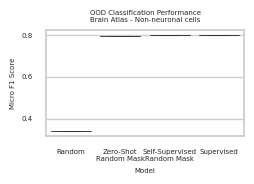

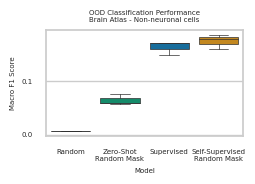

In [47]:
# Manually set the colors for each model type in the order you specified
model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Plot for Micro F1 Score
plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax1 = sns.boxplot(x='Model', y='f1-score: accuracy', data=df.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
# ax1.set_ylim(0.75, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Micro F1 Score', fontdict=font)
ax1.set_title('OOD Classification Performance\nBrain Atlas - Non-neuronal cells', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Brain_Atlas_Micro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Plot for Macro F1 Score
plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax2 = sns.boxplot(x='Model', y='f1-score: macro avg', data=df.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors)
# ax2.set_ylim(0.0, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('Macro F1 Score', fontdict=font)
ax2.set_title('OOD Classification Performance\nBrain Atlas - Non-neuronal cells', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Brain_Atlas_Macro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()


### **Circulating Immune cells -- CV19 infection, vaccination and HC**

- 195,632 cells
- 10x 5' v1 10x 5' v2
- B Cell (21190), CD4-positive, alpha-beta T cell (61350), CD8-positive, alpha-beta T cell (35752), T cell (1407), dendritic cell (3368), gamma-delta T cell (3184), monocyte (38476), mucosal invariant T cell (1244), natural killer cell (28834), stem cell (827) 

In [36]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_Circ_Imm_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.657658,0.061083,0.796547,0.657658,0.054292,0.657658,0.657658,0.055134,0.715888,0.657658,194805.0,194805.0
1,CN_MLP_50prun1_Only Pretrained,0.698976,0.067801,0.821786,0.698976,0.060953,0.698976,0.698976,0.062740,0.750762,0.698976,194805.0,194805.0
2,CN_MLP_50prun2_Only Pretrained,0.726624,0.082375,0.840857,0.726624,0.071754,0.726624,0.726624,0.074578,0.777041,0.726624,194805.0,194805.0
3,CN_MLP_50prun3_Only Pretrained,0.721285,0.071240,0.822088,0.721285,0.062057,0.721285,0.721285,0.065455,0.765492,0.721285,194805.0,194805.0
4,CN_MLP_50prun4_Only Pretrained,0.666338,0.064271,0.799270,0.666338,0.054571,0.666338,0.666338,0.057145,0.724354,0.666338,194805.0,194805.0
5,No_SSL_run0_No SSL,0.900146,0.108625,0.913244,0.900146,0.112794,0.900146,0.900146,0.108211,0.904782,0.900146,194805.0,194805.0
6,No_SSL_run1_No SSL,0.898067,0.107538,0.913165,0.898067,0.112638,0.898067,0.898067,0.107134,0.903620,0.898067,194805.0,194805.0
7,No_SSL_run2_No SSL,0.887457,0.107612,0.904736,0.887457,0.114708,0.887457,0.887457,0.107683,0.894024,0.887457,194805.0,194805.0
8,No_SSL_run3_No SSL,0.897908,0.107846,0.911489,0.897908,0.110063,0.897908,0.897908,0.106210,0.902642,0.897908,194805.0,194805.0
9,No_SSL_run4_No SSL,0.899787,0.114521,0.915579,0.899787,0.119192,0.899787,0.899787,0.114245,0.906040,0.899787,194805.0,194805.0


In [37]:
def extract_model_type(row):
    if 'Only Pretrained' in row['Unnamed: 0']:
        return 'Zero-Shot\nRandom Mask'
    elif 'No SSL' in row['Unnamed: 0']:
        return 'Supervised'
    elif 'SSL_CN' in row['Unnamed: 0']:
        return 'Self-Supervised\nRandom Mask'
    elif 'Random' in row['Unnamed: 0']:
        return 'Random'
    else:
        return 'Error'

# Apply the function to the dataframe
df['Model'] = df.apply(extract_model_type, axis=1)

# Filter outliers
# df = df[~df['Unnamed: 0'].isin(['No_SSL_run0_No SSL', 'No_SSL_run4_No SSL', 'SSL_CN_MLP_50prun1_SSL', 'SSL_CN_MLP_50prun2_SSL', 'CN_MLP_50prun1_Only Pretrained', 'CN_MLP_50prun2_Only Pretrained'])]

# Ensure that the f1-score columns are of float type
df['f1-score: accuracy'] = df['f1-score: accuracy'].astype(float)
df['f1-score: macro avg'] = df['f1-score: macro avg'].astype(float)

# Map the 'Model' column to colors
df['Color'] = df['Model'].map(color_dict)
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Model,Color
0,CN_MLP_50p_Only Pretrained,0.657658,0.061083,0.796547,0.657658,0.054292,0.657658,0.657658,0.055134,0.715888,0.657658,194805.0,194805.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
1,CN_MLP_50prun1_Only Pretrained,0.698976,0.067801,0.821786,0.698976,0.060953,0.698976,0.698976,0.062740,0.750762,0.698976,194805.0,194805.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
2,CN_MLP_50prun2_Only Pretrained,0.726624,0.082375,0.840857,0.726624,0.071754,0.726624,0.726624,0.074578,0.777041,0.726624,194805.0,194805.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
3,CN_MLP_50prun3_Only Pretrained,0.721285,0.071240,0.822088,0.721285,0.062057,0.721285,0.721285,0.065455,0.765492,0.721285,194805.0,194805.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
4,CN_MLP_50prun4_Only Pretrained,0.666338,0.064271,0.799270,0.666338,0.054571,0.666338,0.666338,0.057145,0.724354,0.666338,194805.0,194805.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
5,No_SSL_run0_No SSL,0.900146,0.108625,0.913244,0.900146,0.112794,0.900146,0.900146,0.108211,0.904782,0.900146,194805.0,194805.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
6,No_SSL_run1_No SSL,0.898067,0.107538,0.913165,0.898067,0.112638,0.898067,0.898067,0.107134,0.903620,0.898067,194805.0,194805.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
7,No_SSL_run2_No SSL,0.887457,0.107612,0.904736,0.887457,0.114708,0.887457,0.887457,0.107683,0.894024,0.887457,194805.0,194805.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
8,No_SSL_run3_No SSL,0.897908,0.107846,0.911489,0.897908,0.110063,0.897908,0.897908,0.106210,0.902642,0.897908,194805.0,194805.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
9,No_SSL_run4_No SSL,0.899787,0.114521,0.915579,0.899787,0.119192,0.899787,0.899787,0.114245,0.906040,0.899787,194805.0,194805.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."


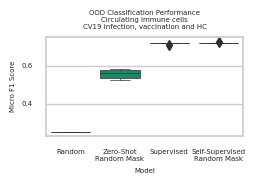

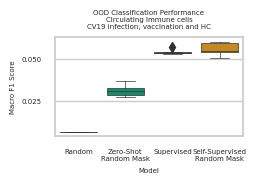

In [38]:
# Manually set the colors for each model type in the order you specified
model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Plot for Micro F1 Score
plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax1 = sns.boxplot(x='Model', y='f1-score: accuracy', data=df.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
# ax1.set_ylim(0.75, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Micro F1 Score', fontdict=font)
ax1.set_title('OOD Classification Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Circ_Imm_Micro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Plot for Macro F1 Score

# Calculate the mean f1-score for each model
mean_scores = df.groupby('Model')['f1-score: macro avg'].mean().sort_values()

# Create a list of models sorted by their mean f1-score
sorted_models = mean_scores.index.tolist()

plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax2 = sns.boxplot(x='Model', y='f1-score: macro avg', data=df.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors, order=sorted_models)
# ax2.set_ylim(0.0, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('Macro F1 Score', fontdict=font)
ax2.set_title('OOD Classification Performance\nCirculating Immune cells\nCV19 infection, vaccination and HC', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Circ_Imm_Macro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()


### **Single-cell analysis of prenatal and postnatal human cortical development**

- 709,372 cells
- 110x 3' v2, 10x 3' v3, 10x multiome
- astrocyte (67868), microglial cell (15857), native cell (15828), neural cell (537452), oligodendrocyte (40875), oligodendrocyte precursor cell (31392)

In [39]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_Cort_Dev_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.642499,0.030629,0.897384,0.642499,0.021505,0.642499,0.642499,0.023128,0.710677,0.642499,156092.0,156092.0
1,CN_MLP_50prun1_Only Pretrained,0.634978,0.029722,0.910616,0.634978,0.020562,0.634978,0.634978,0.022743,0.715370,0.634978,156092.0,156092.0
2,CN_MLP_50prun2_Only Pretrained,0.663282,0.031077,0.907577,0.663282,0.021339,0.663282,0.663282,0.022658,0.719073,0.663282,156092.0,156092.0
3,CN_MLP_50prun3_Only Pretrained,0.706532,0.035473,0.887690,0.706532,0.027811,0.706532,0.706532,0.028957,0.747294,0.706532,156092.0,156092.0
4,CN_MLP_50prun4_Only Pretrained,0.619346,0.027740,0.859237,0.619346,0.019730,0.619346,0.619346,0.020946,0.672547,0.619346,156092.0,156092.0
5,No_SSL_run0_No SSL,0.776798,0.041266,0.908059,0.776798,0.037026,0.776798,0.776798,0.037430,0.804902,0.776798,156092.0,156092.0
6,No_SSL_run1_No SSL,0.779880,0.043597,0.913510,0.779880,0.038466,0.779880,0.779880,0.039522,0.815707,0.779880,156092.0,156092.0
7,No_SSL_run2_No SSL,0.754299,0.041974,0.912432,0.754299,0.035918,0.754299,0.754299,0.037021,0.793382,0.754299,156092.0,156092.0
8,No_SSL_run3_No SSL,0.747803,0.047969,0.909396,0.747803,0.040593,0.747803,0.747803,0.041533,0.782007,0.747803,156092.0,156092.0
9,No_SSL_run4_No SSL,0.754965,0.036201,0.908414,0.754965,0.031244,0.754965,0.754965,0.032037,0.790901,0.754965,156092.0,156092.0


In [40]:
def extract_model_type(row):
    if 'Only Pretrained' in row['Unnamed: 0']:
        return 'Zero-Shot\nRandom Mask'
    elif 'No SSL' in row['Unnamed: 0']:
        return 'Supervised'
    elif 'SSL_CN' in row['Unnamed: 0']:
        return 'Self-Supervised\nRandom Mask'
    elif 'Random' in row['Unnamed: 0']:
        return 'Random'
    else:
        return 'Error'

# Apply the function to the dataframe
df['Model'] = df.apply(extract_model_type, axis=1)

# Filter outliers
# df = df[~df['Unnamed: 0'].isin(['No_SSL_run0_No SSL', 'No_SSL_run4_No SSL', 'SSL_CN_MLP_50prun1_SSL', 'SSL_CN_MLP_50prun2_SSL', 'CN_MLP_50prun1_Only Pretrained', 'CN_MLP_50prun2_Only Pretrained'])]

# Ensure that the f1-score columns are of float type
df['f1-score: accuracy'] = df['f1-score: accuracy'].astype(float)
df['f1-score: macro avg'] = df['f1-score: macro avg'].astype(float)

# Map the 'Model' column to colors
df['Color'] = df['Model'].map(color_dict)
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Model,Color
0,CN_MLP_50p_Only Pretrained,0.642499,0.030629,0.897384,0.642499,0.021505,0.642499,0.642499,0.023128,0.710677,0.642499,156092.0,156092.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
1,CN_MLP_50prun1_Only Pretrained,0.634978,0.029722,0.910616,0.634978,0.020562,0.634978,0.634978,0.022743,0.715370,0.634978,156092.0,156092.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
2,CN_MLP_50prun2_Only Pretrained,0.663282,0.031077,0.907577,0.663282,0.021339,0.663282,0.663282,0.022658,0.719073,0.663282,156092.0,156092.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
3,CN_MLP_50prun3_Only Pretrained,0.706532,0.035473,0.887690,0.706532,0.027811,0.706532,0.706532,0.028957,0.747294,0.706532,156092.0,156092.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
4,CN_MLP_50prun4_Only Pretrained,0.619346,0.027740,0.859237,0.619346,0.019730,0.619346,0.619346,0.020946,0.672547,0.619346,156092.0,156092.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
5,No_SSL_run0_No SSL,0.776798,0.041266,0.908059,0.776798,0.037026,0.776798,0.776798,0.037430,0.804902,0.776798,156092.0,156092.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
6,No_SSL_run1_No SSL,0.779880,0.043597,0.913510,0.779880,0.038466,0.779880,0.779880,0.039522,0.815707,0.779880,156092.0,156092.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
7,No_SSL_run2_No SSL,0.754299,0.041974,0.912432,0.754299,0.035918,0.754299,0.754299,0.037021,0.793382,0.754299,156092.0,156092.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
8,No_SSL_run3_No SSL,0.747803,0.047969,0.909396,0.747803,0.040593,0.747803,0.747803,0.041533,0.782007,0.747803,156092.0,156092.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
9,No_SSL_run4_No SSL,0.754965,0.036201,0.908414,0.754965,0.031244,0.754965,0.754965,0.032037,0.790901,0.754965,156092.0,156092.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."


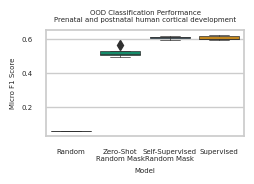

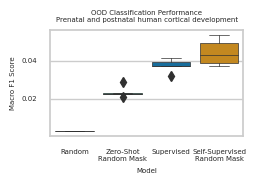

In [42]:
# Manually set the colors for each model type in the order you specified
model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Plot for Micro F1 Score
plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax1 = sns.boxplot(x='Model', y='f1-score: accuracy', data=df.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
# ax1.set_ylim(0.75, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Micro F1 Score', fontdict=font)
ax1.set_title('OOD Classification Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Cort_Dev_Micro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Plot for Macro F1 Score

# Calculate the mean f1-score for each model
mean_scores = df.groupby('Model')['f1-score: macro avg'].mean().sort_values()

# Create a list of models sorted by their mean f1-score
sorted_models = mean_scores.index.tolist()

plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax2 = sns.boxplot(x='Model', y='f1-score: macro avg', data=df.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors, order=sorted_models)
# ax2.set_ylim(0.0, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('Macro F1 Score', fontdict=font)
ax2.set_title('OOD Classification Performance\nPrenatal and postnatal human cortical development', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Cort_Dev_Macro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()


### **Human: Great apes study**

- 156,285 cells
- 10x 3' v3 Smart-seq v4
- L2/3-6 intratelencephalic projecting glutamatergic cortical neuron (85276), L5 something not included (392), L6b glutamatergic cortical neuron (3415), astrocyte of the cerebral cortex (3047), caudial ganglio... not included (844), cerebral cortex endothelial cell (168), chandelier pval (728), cortocothalami... (3118), lamp5 GABAeric... (6416), microglial cell (1263), near-projecting ... (3461), oligodendrocyte (7876), oligodendrocyte precursor cell (2392), pvalb GABAergic (11778), sncg GABAergic (2025), sst GABAergic cortical interneuron (13593), vascular leptomeningeal cell (276), vip GABAergic cortical interneuron (10219)

In [46]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_Great_Apes_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.305489,0.195139,0.824347,0.305489,0.055487,0.305489,0.305489,0.067644,0.401105,0.305489,155449.0,155449.0
1,CN_MLP_50prun1_Only Pretrained,0.208139,0.168213,0.931240,0.208139,0.042885,0.208139,0.208139,0.051183,0.302485,0.208139,155449.0,155449.0
2,CN_MLP_50prun2_Only Pretrained,0.348738,0.122933,0.734191,0.348738,0.042351,0.348738,0.348738,0.052680,0.428058,0.348738,155449.0,155449.0
3,CN_MLP_50prun3_Only Pretrained,0.389440,0.202441,0.808385,0.389440,0.073363,0.389440,0.389440,0.086623,0.478549,0.389440,155449.0,155449.0
4,CN_MLP_50prun4_Only Pretrained,0.187560,0.120917,0.672435,0.187560,0.039214,0.187560,0.187560,0.045148,0.260133,0.187560,155449.0,155449.0
5,No_SSL_run0_No SSL,0.628007,0.162138,0.976363,0.628007,0.107048,0.628007,0.628007,0.123531,0.752099,0.628007,155449.0,155449.0
6,No_SSL_run1_No SSL,0.266544,0.197367,0.976395,0.266544,0.082031,0.266544,0.266544,0.097853,0.367401,0.266544,155449.0,155449.0
7,No_SSL_run2_No SSL,0.304897,0.124402,0.991850,0.304897,0.048141,0.304897,0.304897,0.061073,0.438515,0.304897,155449.0,155449.0
8,No_SSL_run3_No SSL,0.240304,0.150660,0.989123,0.240304,0.063605,0.240304,0.240304,0.080925,0.338258,0.240304,155449.0,155449.0
9,No_SSL_run4_No SSL,0.405033,0.146198,0.980758,0.405033,0.058551,0.405033,0.405033,0.075018,0.549833,0.405033,155449.0,155449.0


In [44]:
def extract_model_type(row):
    if 'Only Pretrained' in row['Unnamed: 0']:
        return 'Zero-Shot\nRandom Mask'
    elif 'No SSL' in row['Unnamed: 0']:
        return 'Supervised'
    elif 'SSL_CN' in row['Unnamed: 0']:
        return 'Self-Supervised\nRandom Mask'
    elif 'Random' in row['Unnamed: 0']:
        return 'Random'
    else:
        return 'Error'

# Apply the function to the dataframe
df['Model'] = df.apply(extract_model_type, axis=1)

# Filter outliers
# df = df[~df['Unnamed: 0'].isin(['No_SSL_run0_No SSL', 'No_SSL_run4_No SSL', 'SSL_CN_MLP_50prun1_SSL', 'SSL_CN_MLP_50prun2_SSL', 'CN_MLP_50prun1_Only Pretrained', 'CN_MLP_50prun2_Only Pretrained'])]

# Ensure that the f1-score columns are of float type
df['f1-score: accuracy'] = df['f1-score: accuracy'].astype(float)
df['f1-score: macro avg'] = df['f1-score: macro avg'].astype(float)

# Map the 'Model' column to colors
df['Color'] = df['Model'].map(color_dict)
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Model,Color
0,CN_MLP_50p_Only Pretrained,0.305489,0.195139,0.824347,0.305489,0.055487,0.305489,0.305489,0.067644,0.401105,0.305489,155449.0,155449.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
1,CN_MLP_50prun1_Only Pretrained,0.208139,0.168213,0.931240,0.208139,0.042885,0.208139,0.208139,0.051183,0.302485,0.208139,155449.0,155449.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
2,CN_MLP_50prun2_Only Pretrained,0.348738,0.122933,0.734191,0.348738,0.042351,0.348738,0.348738,0.052680,0.428058,0.348738,155449.0,155449.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
3,CN_MLP_50prun3_Only Pretrained,0.389440,0.202441,0.808385,0.389440,0.073363,0.389440,0.389440,0.086623,0.478549,0.389440,155449.0,155449.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
4,CN_MLP_50prun4_Only Pretrained,0.187560,0.120917,0.672435,0.187560,0.039214,0.187560,0.187560,0.045148,0.260133,0.187560,155449.0,155449.0,Zero-Shot\nRandom Mask,"(0.00784313725490196, 0.6196078431372549, 0.45..."
5,No_SSL_run0_No SSL,0.628007,0.162138,0.976363,0.628007,0.107048,0.628007,0.628007,0.123531,0.752099,0.628007,155449.0,155449.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
6,No_SSL_run1_No SSL,0.266544,0.197367,0.976395,0.266544,0.082031,0.266544,0.266544,0.097853,0.367401,0.266544,155449.0,155449.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
7,No_SSL_run2_No SSL,0.304897,0.124402,0.991850,0.304897,0.048141,0.304897,0.304897,0.061073,0.438515,0.304897,155449.0,155449.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
8,No_SSL_run3_No SSL,0.240304,0.150660,0.989123,0.240304,0.063605,0.240304,0.240304,0.080925,0.338258,0.240304,155449.0,155449.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."
9,No_SSL_run4_No SSL,0.405033,0.146198,0.980758,0.405033,0.058551,0.405033,0.405033,0.075018,0.549833,0.405033,155449.0,155449.0,Supervised,"(0.00392156862745098, 0.45098039215686275, 0.6..."


In [19]:
np.std((0.211831, 0.164773, 0.240348, 0.107757, 0.173766))

0.0450430990807693

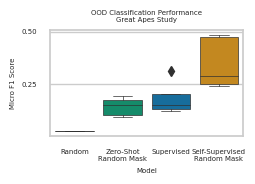

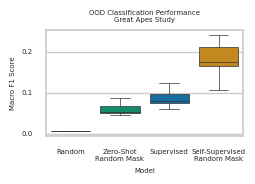

In [45]:
# Manually set the colors for each model type in the order you specified
model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Plot for Micro F1 Score
plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax1 = sns.boxplot(x='Model', y='f1-score: accuracy', data=df.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
# ax1.set_ylim(0.75, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax1.set_xticklabels(ax1.get_xticklabels(), **tick_font)
ax1.set_yticklabels(ax1.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax1.set_xlabel('Model', fontdict=font)
ax1.set_ylabel('Micro F1 Score', fontdict=font)
ax1.set_title('OOD Classification Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Great_Apes_Micro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

# Plot for Macro F1 Score

# Calculate the mean f1-score for each model
mean_scores = df.groupby('Model')['f1-score: macro avg'].mean().sort_values()

# Create a list of models sorted by their mean f1-score
sorted_models = mean_scores.index.tolist()

plt.figure(figsize=(2.7, 2))  # Adjusted for consistency with other figures
ax2 = sns.boxplot(x='Model', y='f1-score: macro avg', data=df.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors, order=sorted_models)
# ax2.set_ylim(0.0, 1.0)  # Uncomment if you want to set a limit for the y-axis

# Set the font for the tick labels
ax2.set_xticklabels(ax2.get_xticklabels(), **tick_font)
ax2.set_yticklabels(ax2.get_yticklabels(), **tick_font)

# Set the font for the axis labels and title
ax2.set_xlabel('Model', fontdict=font)
ax2.set_ylabel('Macro F1 Score', fontdict=font)
ax2.set_title('OOD Classification Performance\nGreat Apes Study', fontdict=font)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/OOD_Great_Apes_Macro_F1_Boxplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()


# Figure 3

Does pretraining on a large, auxiliary dataset improve performance on a specific, known dataset to be classified?

### 1. HLCA

In [64]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_hlca_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.744914,0.728651,0.766407,0.744914,0.659907,0.744914,0.744914,0.669560,0.745139,0.744914,117517.0,117517.0
2,CN_MLP_50prun1_Only Pretrained,0.782049,0.753200,0.799042,0.782049,0.719410,0.782049,0.782049,0.719669,0.783358,0.782049,117517.0,117517.0
4,CN_MLP_50prun2_Only Pretrained,0.809279,0.759255,0.823796,0.809279,0.761227,0.809279,0.809279,0.750102,0.811087,0.809279,117517.0,117517.0
6,CN_MLP_50prun3_Only Pretrained,0.787886,0.757231,0.807285,0.787886,0.722921,0.787886,0.787886,0.719856,0.789740,0.787886,117517.0,117517.0
8,CN_MLP_50prun4_Only Pretrained,0.737570,0.723118,0.748719,0.737570,0.666234,0.737570,0.737570,0.677196,0.735758,0.737570,117517.0,117517.0
10,CN_MLP_gene_program_C8_25p_Only Pretrained,0.852464,0.786918,0.871100,0.852464,0.789839,0.852464,0.852464,0.777939,0.857082,0.852464,117517.0,117517.0
20,No_SSL_new_run0_HLCA_No SSL,0.948748,0.921724,0.951847,0.948748,0.939486,0.948748,0.948748,0.928634,0.949850,0.948748,117517.0,117517.0
308,No_SSL_new_run1_HLCA_No SSL,0.950169,0.929209,0.954499,0.950169,0.945958,0.950169,0.950169,0.935237,0.951775,0.950169,117517.0,117517.0
340,No_SSL_new_run2_HLCA_No SSL,0.946603,0.926998,0.949465,0.946603,0.940133,0.946603,0.946603,0.932046,0.947467,0.946603,117517.0,117517.0
372,No_SSL_new_run3_HLCA_No SSL,0.948646,0.926567,0.951985,0.948646,0.943178,0.948646,0.948646,0.932772,0.949710,0.948646,117517.0,117517.0


In [65]:
models_to_select = ['CN_MLP_50p_Only Pretrained', 
                    'CN_MLP_50prun1_Only Pretrained', 
                    'CN_MLP_50prun2_Only Pretrained', 
                    'CN_MLP_50prun3_Only Pretrained', 
                    'CN_MLP_50prun4_Only Pretrained', 
                    'No_SSL_new_run0_HLCA_No SSL',
                    'No_SSL_new_run1_HLCA_No SSL',
                    'No_SSL_new_run2_HLCA_No SSL',
                    'No_SSL_new_run3_HLCA_No SSL',
                    'No_SSL_new_run4_HLCA_No SSL',
                    'Random',
                    'SSL_CN_MLP_50pnew_run0_HLCA_SSL',
                    'SSL_CN_MLP_50prun1_HLCA_SSL',
                    'SSL_CN_MLP_50prun2_HLCA_SSL',
                    'SSL_CN_MLP_50prun3_HLCA_SSL',
                    'SSL_CN_MLP_50prun4_HLCA_SSL',
                   ]

df_new_run = df[df['Unnamed: 0'].isin(models_to_select)]
df_new_run

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.744914,0.728651,0.766407,0.744914,0.659907,0.744914,0.744914,0.669560,0.745139,0.744914,117517.0,117517.0
2,CN_MLP_50prun1_Only Pretrained,0.782049,0.753200,0.799042,0.782049,0.719410,0.782049,0.782049,0.719669,0.783358,0.782049,117517.0,117517.0
4,CN_MLP_50prun2_Only Pretrained,0.809279,0.759255,0.823796,0.809279,0.761227,0.809279,0.809279,0.750102,0.811087,0.809279,117517.0,117517.0
6,CN_MLP_50prun3_Only Pretrained,0.787886,0.757231,0.807285,0.787886,0.722921,0.787886,0.787886,0.719856,0.789740,0.787886,117517.0,117517.0
8,CN_MLP_50prun4_Only Pretrained,0.737570,0.723118,0.748719,0.737570,0.666234,0.737570,0.737570,0.677196,0.735758,0.737570,117517.0,117517.0
20,No_SSL_new_run0_HLCA_No SSL,0.948748,0.921724,0.951847,0.948748,0.939486,0.948748,0.948748,0.928634,0.949850,0.948748,117517.0,117517.0
308,No_SSL_new_run1_HLCA_No SSL,0.950169,0.929209,0.954499,0.950169,0.945958,0.950169,0.950169,0.935237,0.951775,0.950169,117517.0,117517.0
340,No_SSL_new_run2_HLCA_No SSL,0.946603,0.926998,0.949465,0.946603,0.940133,0.946603,0.946603,0.932046,0.947467,0.946603,117517.0,117517.0
372,No_SSL_new_run3_HLCA_No SSL,0.948646,0.926567,0.951985,0.948646,0.943178,0.948646,0.948646,0.932772,0.949710,0.948646,117517.0,117517.0
404,No_SSL_new_run4_HLCA_No SSL,0.948510,0.921018,0.951949,0.948510,0.943032,0.948510,0.948510,0.929915,0.949741,0.948510,117517.0,117517.0


In [78]:
np.mean((0.744914, 0.782049, 0.809279, 0.787886, 0.737570))

0.7723395999999999

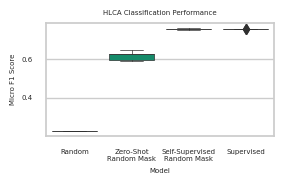

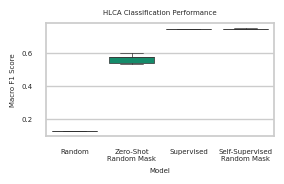

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your data processing code here...

# Step 1: Filter to include only 'new_run' entries
# df_new_run = df[df['Unnamed: 0'].str.contains('new_run')]

# Step 2: Rename model types
def rename_model(row):
    if 'Only Pretrained' in row:
        return 'Zero-Shot\nRandom Mask'
    elif 'HLCA_No SSL' in row:
        return 'Supervised'
    elif 'HLCA_SSL' in row:
        return 'Self-Supervised\nRandom Mask'
    elif 'Random' in row:
        return 'Random'
    else:
        return row

df_new_run['Unnamed: 0'] = df_new_run['Unnamed: 0'].apply(rename_model)

model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Step 3: Calculate mean and std for each model
mean_std_df = df_new_run.groupby('Unnamed: 0')['f1-score: macro avg', 'f1-score: accuracy'].agg(['mean', 'std'])

# Step 4: Create box plots
sns.set_palette("colorblind")

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # This will be for titles and labels

# Start plotting
plt.figure(figsize=(3,2))
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: accuracy', data=df_new_run.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Micro F1 Score', fontdict=font)
ax.set_title('HLCA Classification Performance', fontdict=font)

# Set font for all tick labels to match the fontdict
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
plt.savefig(RESULT_PATH + "/classification/HLCA_Clf_Micro_F1.svg", bbox_inches='tight')  # Save as SVG

plt.tight_layout()
plt.show()

# Repeat for the second plot
plt.figure(figsize=(3, 2))
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: macro avg', data=df_new_run.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Macro F1 Score', fontdict=font)
ax.set_title('HLCA Classification Performance', fontdict=font)
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
plt.savefig(RESULT_PATH + "/classification/HLCA_Clf_Macro_F1.svg", bbox_inches='tight')  # Save as SVG

plt.tight_layout()
plt.show()


In [41]:
# Step 1: Filter to include only 'new_run' entries
df_new_run = df# [df['Unnamed: 0'].str.contains('new_run')]

# Step 2: Rename model types
def rename_model(row):
    if 'SSL_CN' in row:
        return 'Self-Supervised\nRandom Mask'
    elif 'No SSL' in row:
        return 'Supervised'
    elif 'Only Pretrained' in row:
        return "Zero-Shot\nRandom Mask"
    elif 'Random' in row:
        return 'Random'
    else:
        return row

df_new_run['Unnamed: 0'] = df_new_run['Unnamed: 0'].apply(rename_model)

# Step 3: Calculate mean and std for each model
mean_std_df = df_new_run.groupby('Unnamed: 0')['f1-score: macro avg', 'f1-score: accuracy'].agg(['mean', 'std'])

# Map the 'Model' column to colors
df_new_run['Color'] = df_new_run['Unnamed: 0'].map(color_dict)

df_new_run

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg,Color
0,Zero-Shot\nRandom Mask,0.744914,0.728651,0.766407,0.744914,0.659907,0.744914,0.744914,0.669560,0.745139,0.744914,117517.0,117517.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
1,Zero-Shot\nRandom Mask,0.782049,0.753200,0.799042,0.782049,0.719410,0.782049,0.782049,0.719669,0.783358,0.782049,117517.0,117517.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
2,Zero-Shot\nRandom Mask,0.809279,0.759255,0.823796,0.809279,0.761227,0.809279,0.809279,0.750102,0.811087,0.809279,117517.0,117517.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
3,Zero-Shot\nRandom Mask,0.787886,0.757231,0.807285,0.787886,0.722921,0.787886,0.787886,0.719856,0.789740,0.787886,117517.0,117517.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
4,Zero-Shot\nRandom Mask,0.737570,0.723118,0.748719,0.737570,0.666234,0.737570,0.737570,0.677196,0.735758,0.737570,117517.0,117517.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
5,Zero-Shot\nRandom Mask,0.852464,0.786918,0.871100,0.852464,0.789839,0.852464,0.852464,0.777939,0.857082,0.852464,117517.0,117517.0,"(0.00784313725490196, 0.6196078431372549, 0.45..."
10,Supervised,0.948748,0.921724,0.951847,0.948748,0.939486,0.948748,0.948748,0.928634,0.949850,0.948748,117517.0,117517.0,"(0.00392156862745098, 0.45098039215686275, 0.6..."
154,Supervised,0.950169,0.929209,0.954499,0.950169,0.945958,0.950169,0.950169,0.935237,0.951775,0.950169,117517.0,117517.0,"(0.00392156862745098, 0.45098039215686275, 0.6..."
170,Supervised,0.946603,0.926998,0.949465,0.946603,0.940133,0.946603,0.946603,0.932046,0.947467,0.946603,117517.0,117517.0,"(0.00392156862745098, 0.45098039215686275, 0.6..."
186,Supervised,0.948646,0.926567,0.951985,0.948646,0.943178,0.948646,0.948646,0.932772,0.949710,0.948646,117517.0,117517.0,"(0.00392156862745098, 0.45098039215686275, 0.6..."


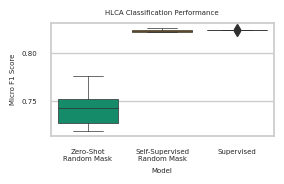

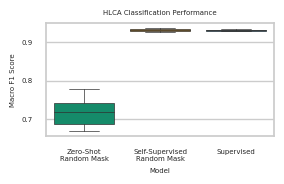

In [42]:
# Function to generate color palette based on sorted model order
def get_palette(df, col_name):
    sorted_models = df.sort_values(col_name)['Unnamed: 0'].unique()
    return [color_dict[model] for model in sorted_models]

model_c

# Plot for Micro F1 Score
plt.figure(figsize=(3, 2))
palette = get_palette(df_new_run, 'f1-score: accuracy')
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: accuracy', data=df_new_run.sort_values('f1-score: accuracy'), linewidth=0.5, palette=palette)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Micro F1 Score', fontdict=font)
ax.set_title('HLCA Classification Performance', fontdict=font)
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
# plt.savefig(RESULT_PATH + "/classification/HLCA_Clf_Micro_F1.svg", bbox_inches='tight')
plt.tight_layout()
plt.show()

# Repeat for the second plot
plt.figure(figsize=(3, 2))
palette = get_palette(df_new_run, 'f1-score: macro avg')
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: macro avg', data=df_new_run.sort_values('f1-score: macro avg'), linewidth=0.5, palette=palette)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Macro F1 Score', fontdict=font)
ax.set_title('HLCA Classification Performance', fontdict=font)
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
# plt.savefig(RESULT_PATH + "/classification/HLCA_Clf_Macro_F1.svg", bbox_inches='tight')
plt.tight_layout()
plt.show()

Histogram

In [58]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_per_class_report_hlca_merged_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,F1_Self-Supervised,Cell Count,Cell Type,F1_Supervised
0,0,0.992313,6172,B cell,0.993351
1,1,0.918387,2046,CD1c-positive myeloid dendritic cell,0.910165
2,2,0.960894,9870,"CD4-positive, alpha-beta T cell",0.956418
3,3,0.963771,13203,"CD8-positive, alpha-beta T cell",0.961713
4,4,0.969980,737,T cell,0.981132
5,5,0.971144,12084,alveolar macrophage,0.969715
6,6,0.974449,1144,alveolar type 1 fibroblast cell,0.966964
7,7,0.902367,652,alveolar type 2 fibroblast cell,0.900073
8,8,0.983123,3070,bronchus fibroblast of lung,0.978417
9,9,0.950142,1778,capillary endothelial cell,0.951412


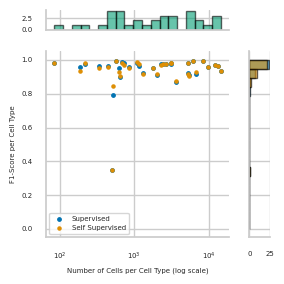

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use a colorblind-friendly palette
sns.set_palette("colorblind")
colors = sns.color_palette()

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # Adjust the size as needed

# Create a JointGrid with specified height
g = sns.JointGrid(x='Cell Count', y='F1_Supervised', data=df, height=3, marginal_ticks=True, space=0.2)
g = g.plot_joint(plt.scatter, s=6, color=colors[0], label="Supervised")  # Model A in one color
g.ax_joint.scatter(df['Cell Count'], df['F1_Self-Supervised'], s=5, color=colors[1], label="Self Supervised")  # Model B in another color

# Histograms
g.ax_marg_x.hist(df['Cell Count'], bins=np.geomspace(df['Cell Count'].min(), df['Cell Count'].max(), 20), alpha=.6, edgecolor='black', color=colors[2])
g.ax_marg_y.hist(df['F1_Supervised'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black', color=colors[0])
g.ax_marg_y.hist(df['F1_Self-Supervised'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black', color=colors[1])

# Labels & Title
g.set_axis_labels('Number of Cells per Cell Type (log scale)', 'F1-Score per Cell Type', **font)
g.ax_joint.set_xscale('log')

# Adjust legend with font properties
g.ax_joint.legend(prop=font)

# Apply font properties to all tick labels
for ax in [g.ax_joint, g.ax_marg_x, g.ax_marg_y]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(font['size'])
        label.set_family(font['family'])

# Save the plot
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/HLCA_per_celltype_perf.svg")
plt.show()


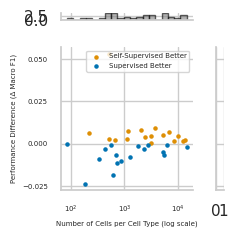

In [63]:
# Calculate the difference between F1 scores of Self-Supervised and Supervised
df['F1_Difference'] = df['F1_Self-Supervised'] - df['F1_Supervised']

# Filter the data for positive, negative, and equal non-zero F1_Difference
positive_diff = df[df['F1_Difference'] > 0]
negative_diff = df[df['F1_Difference'] < 0]
equal_non_zero_diff = df[(df['F1_Difference'] == 0)] # & (df['F1_Self-Supervised'] != 0) & (df['F1_Supervised'] != 0)]

# Create a JointGrid without the right histogram (deactivate marginal plots)
g = sns.JointGrid(x='Cell Count', y='F1_Difference', data=df, height=2.5, marginal_ticks=True, space=0.2)

# Plot the scatter points with color depending on the sign of the F1_Difference
# Points where Self-Supervised is better (positive difference)
g.ax_joint.scatter(positive_diff['Cell Count'], positive_diff['F1_Difference'], 
                   s=5, color=color_ssl, label="Self-Supervised Better")

# Points where Supervised is better (negative difference)
g.ax_joint.scatter(negative_diff['Cell Count'], negative_diff['F1_Difference'], 
                   s=5, color=color_supervised, label="Supervised Better")

# Points where performance is equal and non-zero
# g.ax_joint.scatter(equal_non_zero_diff['Cell Count'], equal_non_zero_diff['F1_Difference'], 
#                    s=5, color=color_else2, label="Equal Performance (F1=0)")

# Histogram on the top
g.ax_marg_x.hist(df['Cell Count'], bins=np.geomspace(df['Cell Count'].min(), df['Cell Count'].max(), 20), 
                 alpha=.6, edgecolor='black', color='grey')

# Labels & Title
g.set_axis_labels('Number of Cells per Cell Type (log scale)', 'Performance Difference (Δ Macro F1)', **font)
g.ax_joint.set_xscale('log')

# Adjust legend with font properties
g.ax_joint.legend(prop=font)

# Apply font properties to all tick labels
for label in g.ax_joint.get_xticklabels() + g.ax_joint.get_yticklabels():
    label.set_fontsize(font['size'])
    label.set_family(font['family'])

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/HLCA_Per_CT_Difference.svg", bbox_inches='tight')  # Save as SVG
plt.show()


Confusion Matrix

In [144]:
y_pred_supervised = np.load(os.path.join(RESULT_PATH, 'classification', 'new_predicted_labels_No_SSL_new_run1_HLCA_No SSL.npy'))
y_pred_ssl = np.load(os.path.join(RESULT_PATH, 'classification', 'new_predicted_labels_SSL_CN_MLP_50prun4_HLCA_SSL.npy'))
y_true = np.load(os.path.join(RESULT_PATH, 'classification', 'new_true_labels_No_SSL_new_run1_HLCA_No SSL.npy'))  # same as for ssl, deterministic data loader


In [145]:
# Calculate correct predictions
correct_supervised = np.equal(y_pred_supervised, y_true).astype(int)
correct_ssl = np.equal(y_pred_ssl, y_true).astype(int)

# Calculate the sum of correct predictions for each class
unique_classes = np.unique(y_true)
correct_counts_supervised = [np.sum(correct_supervised[y_true == cls]) for cls in unique_classes]
correct_counts_ssl = [np.sum(correct_ssl[y_true == cls]) for cls in unique_classes]

# Calculate the differences
differences = np.array(correct_counts_ssl) - np.array(correct_counts_supervised)

In [146]:
differences

array([   7,  -12,   82,  -59,   -1,  121,   23,   -7,    8,   -7,   -2,
       -102,  110,  -12,   -2,  135,    0,  -10,   -3,   -3,   -1,  -95,
         42,  -16,  -13,    0,    1,  -37,    9,    1,  -19,   12,  -21,
         -3])

In [147]:
cell_type_mapping = pd.read_parquet(
        os.path.join(DATA_PATH, "categorical_lookup/cell_type.parquet")
    )
cell_type_mapping['label'] = cell_type_mapping['label'].str.title()


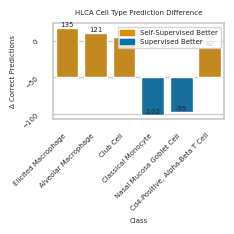

In [150]:
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Class': unique_classes,
    'Difference': differences
})

# Sort by absolute difference and select top n classes
n = 6  # Replace with your desired number of classes
df_plot['Absolute Difference'] = df_plot['Difference'].abs()
df_top_n = df_plot.sort_values(by='Absolute Difference', ascending=False).head(n)



# Assign colors based on the sign of the difference
df_top_n['Color'] = df_top_n['Difference'].apply(lambda x: color_ssl if x > 0 else color_supervised)

# Create a mapping dictionary from integer labels to string names
label_to_name_dict = cell_type_mapping['label'].to_dict()

# Replace integer class labels in df_top_n with string names
df_top_n['Class'] = df_top_n['Class'].map(label_to_name_dict)

# Plotting
bar_colors = [color_ssl, color_ssl, color_ssl, color_supervised, color_supervised, color_ssl]

plt.figure(figsize=(2.5, 2.5))
ax = sns.barplot(x='Class', y='Difference', data=df_top_n, palette=bar_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, **tick_font, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, **tick_font, ha='right')
ax.set_xlabel('Class', fontdict=font)
ax.set_ylabel('Δ Correct Predictions', fontdict=font)
ax.set_title('HLCA Cell Type Prediction Difference', fontdict=font)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=font['size'])
    
# Create legend handles
ssl_patch = mpatches.Patch(color=color_ssl, label='Self-Supervised Better')
supervised_patch = mpatches.Patch(color=color_supervised, label='Supervised Better')

# Add legend to the plot
ax.legend(handles=[ssl_patch, supervised_patch], loc='upper right', prop=font)


plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/hlca_biggest_difference_barplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

In [64]:
conf_matrix_supervised = pd.read_csv(os.path.join(RESULT_PATH, 'classification', 'conf_matrix_No_SSL_new_run1_HLCA_No SSL.csv'), index_col='Unnamed: 0')
conf_matrix_ssl = pd.read_csv(os.path.join(RESULT_PATH, 'classification', 'conf_matrix_SSL_CN_MLP_50prun4_HLCA_SSL.csv'), index_col='Unnamed: 0')

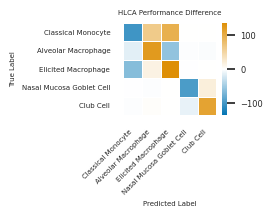

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# Compute the difference matrix
conf_matrix_difference = conf_matrix_ssl - conf_matrix_supervised

# Identify the top N cell types with the largest absolute differences
N = 5  # Number of top differences to display
top_differences = conf_matrix_difference.abs().sum(axis=1).nlargest(N).index

# Create a subset DataFrame for these top differences
conf_matrix_subset = conf_matrix_difference.loc[top_differences, top_differences]

# Capitalize the first letter of each word in the columns
conf_matrix_subset.columns = conf_matrix_subset.columns.str.title()

# Capitalize the first letter of each word in the index
conf_matrix_subset.index = conf_matrix_subset.index.str.title()

# Create a custom diverging colormap
top = mcolors.to_rgba(color_ssl)
bottom = mcolors.to_rgba(color_supervised)
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_map", [bottom, "white", top])

# Define the range for the colormap
max_abs_value = np.abs(conf_matrix_subset.values).max()
vmin, vmax = -max_abs_value, max_abs_value

# Create heatmap without annotations for the subset difference matrix
plt.figure(figsize=(1.5, 1.2))  # Adjust figure size as needed for better visibility
ax = sns.heatmap(conf_matrix_subset, annot=False, cmap=custom_colormap, linewidths=.5, vmin=vmin, vmax=vmax)

# Set the font for the tick labels
ax.set_xticklabels(conf_matrix_subset.columns, **tick_font, rotation=45, ha='right')
ax.set_yticklabels(conf_matrix_subset.index, **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('HLCA Performance Difference', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(6)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/hlca_biggest_difference_confusion_matrix.svg", bbox_inches='tight')  # Save as SVG
plt.show()


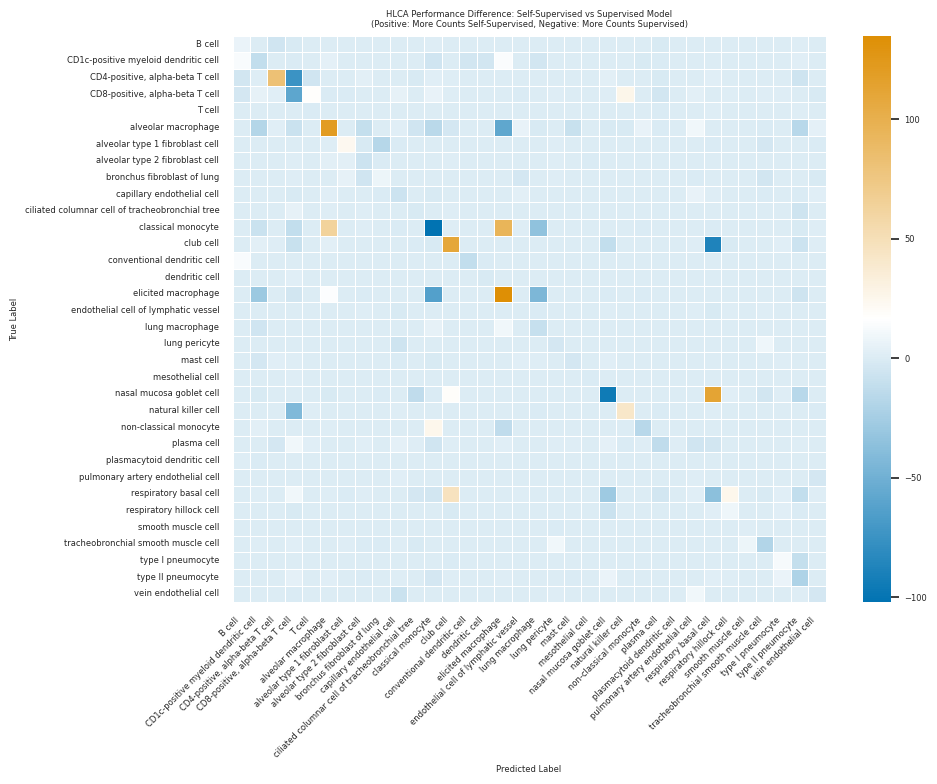

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# Compute the difference matrix
conf_matrix_difference = conf_matrix_ssl - conf_matrix_supervised

# Create a custom diverging colormap
top = mcolors.to_rgba(color_ssl)
bottom = mcolors.to_rgba(color_supervised)
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_map", [bottom, "white", top])

# Create heatmap without annotations for the difference matrix
plt.figure(figsize=(10, 8))  # Adjust figure size as needed for better visibility
ax = sns.heatmap(conf_matrix_difference, annot=False, cmap=custom_colormap, linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(conf_matrix_difference.columns, **tick_font, rotation=45, ha='right')
ax.set_yticklabels(conf_matrix_difference.index, **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('HLCA Performance Difference: Self-Supervised vs Supervised Model\n(Positive: More Counts Self-Supervised, Negative: More Counts Supervised)', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(6)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/hlca_difference_confusion_matrix.svg", bbox_inches='tight')  # Save as SVG
plt.show()


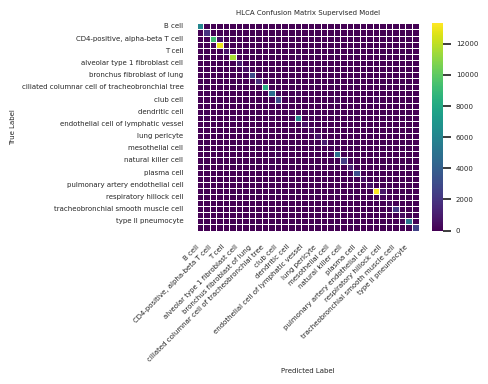

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'conf_matrix_supervised' is your DataFrame with the confusion matrix data

# Set the style for the plots
sns.set_theme()
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Create heatmap without annotations
plt.figure(figsize=(5, 4))  # Adjust figure size as needed
ax = sns.heatmap(conf_matrix_supervised, annot=False, cmap='viridis', linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(ax.get_xticklabels(), **tick_font, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('HLCA Confusion Matrix Supervised Model', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(5)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/confusion_matrix_hlca_supervised.svg", bbox_inches='tight')  # Save as SVG
plt.show()


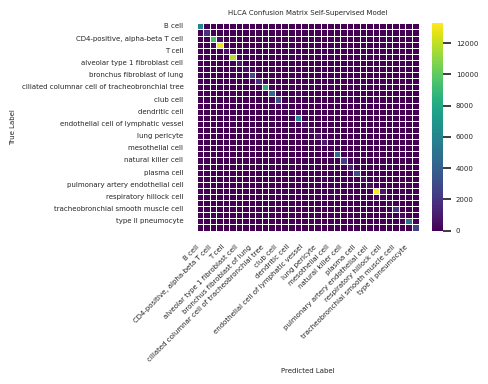

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'conf_matrix_supervised' is your DataFrame with the confusion matrix data

# Set the style for the plots
sns.set_theme()
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Create heatmap without annotations
plt.figure(figsize=(5, 4))  # Adjust figure size as needed
ax = sns.heatmap(conf_matrix_ssl, annot=False, cmap='viridis', linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(ax.get_xticklabels(), **tick_font, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('HLCA Confusion Matrix Self-Supervised Model', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(5)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/confusion_matrix_hlca_ssl.svg", bbox_inches='tight')  # Save as SVG
plt.show()


### 2. PBMC

In [68]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_pbmc_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Identify the rows to be dropped by their index values
rows_to_drop = ['No_SSL_new_run5_PBMC_No SSL', 'No_SSL_new_run2_PBMC_No SSL', 'No_SSL_run0_PBMC_No SSL']

# Drop the specified rows
df = df[~df['Unnamed: 0'].isin(rows_to_drop)]

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.657838,0.569915,0.663836,0.657838,0.402285,0.657838,0.657838,0.435423,0.642525,0.657838,57616.0,57616.0
2,CN_MLP_50prun1_Only Pretrained,0.681130,0.626810,0.695513,0.681130,0.423367,0.681130,0.681130,0.456538,0.670682,0.681130,57616.0,57616.0
4,CN_MLP_50prun2_Only Pretrained,0.727992,0.706924,0.739441,0.727992,0.508157,0.727992,0.727992,0.557645,0.716734,0.727992,57616.0,57616.0
6,CN_MLP_50prun3_Only Pretrained,0.702843,0.643029,0.704047,0.702843,0.448807,0.702843,0.702843,0.486987,0.687070,0.702843,57616.0,57616.0
8,CN_MLP_50prun4_Only Pretrained,0.674552,0.551052,0.674238,0.674552,0.399385,0.674552,0.674552,0.435953,0.658341,0.674552,57616.0,57616.0
10,CN_MLP_gene_program_C8_25p_Only Pretrained,0.733945,0.626897,0.731231,0.733945,0.508202,0.733945,0.733945,0.541719,0.719396,0.733945,57616.0,57616.0
20,No_SSL_new_run0_PBMC_No SSL,0.843724,0.740668,0.844368,0.843724,0.701412,0.843724,0.843724,0.706138,0.840942,0.843724,57616.0,57616.0
884,No_SSL_new_run1_PBMC_No SSL,0.841502,0.738655,0.844016,0.841502,0.717790,0.841502,0.841502,0.707267,0.839184,0.841502,57616.0,57616.0
1076,No_SSL_new_run3_PBMC_No SSL,0.836504,0.743899,0.839574,0.836504,0.677720,0.836504,0.836504,0.701583,0.833660,0.836504,57616.0,57616.0
1172,No_SSL_new_run4_PBMC_No SSL,0.843620,0.732410,0.845363,0.843620,0.697213,0.843620,0.843620,0.690500,0.840926,0.843620,57616.0,57616.0


In [69]:
models_to_select = ['CN_MLP_50p_Only Pretrained', 
                    'CN_MLP_50prun1_Only Pretrained', 
                    'CN_MLP_50prun2_Only Pretrained', 
                    'CN_MLP_50prun3_Only Pretrained', 
                    'CN_MLP_50prun4_Only Pretrained', 
                    'No_SSL_new_run0_PBMC_No SSL',
                    'No_SSL_new_run1_PBMC_No SSL',
                    'No_SSL_new_run2_PBMC_No SSL',
                    'No_SSL_new_run3_PBMC_No SSL',
                    'No_SSL_new_run4_PBMC_No SSL',
                    'Random',
                    'SSL_CN_MLP_50pnew_run0_PBMC_SSL',
                    'SSL_CN_MLP_50pnew_run1_PBMC_SSL',
                    'SSL_CN_MLP_50pnew_run2_PBMC_SSL',
                    'SSL_CN_MLP_50pnew_run3_PBMC_SSL',
                    'SSL_CN_MLP_50pnew_run4_PBMC_SSL',
                   ]

df_new_run = df[df['Unnamed: 0'].isin(models_to_select)]
df_new_run

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.657838,0.569915,0.663836,0.657838,0.402285,0.657838,0.657838,0.435423,0.642525,0.657838,57616.0,57616.0
2,CN_MLP_50prun1_Only Pretrained,0.681130,0.626810,0.695513,0.681130,0.423367,0.681130,0.681130,0.456538,0.670682,0.681130,57616.0,57616.0
4,CN_MLP_50prun2_Only Pretrained,0.727992,0.706924,0.739441,0.727992,0.508157,0.727992,0.727992,0.557645,0.716734,0.727992,57616.0,57616.0
6,CN_MLP_50prun3_Only Pretrained,0.702843,0.643029,0.704047,0.702843,0.448807,0.702843,0.702843,0.486987,0.687070,0.702843,57616.0,57616.0
8,CN_MLP_50prun4_Only Pretrained,0.674552,0.551052,0.674238,0.674552,0.399385,0.674552,0.674552,0.435953,0.658341,0.674552,57616.0,57616.0
20,No_SSL_new_run0_PBMC_No SSL,0.843724,0.740668,0.844368,0.843724,0.701412,0.843724,0.843724,0.706138,0.840942,0.843724,57616.0,57616.0
884,No_SSL_new_run1_PBMC_No SSL,0.841502,0.738655,0.844016,0.841502,0.717790,0.841502,0.841502,0.707267,0.839184,0.841502,57616.0,57616.0
1076,No_SSL_new_run3_PBMC_No SSL,0.836504,0.743899,0.839574,0.836504,0.677720,0.836504,0.836504,0.701583,0.833660,0.836504,57616.0,57616.0
1172,No_SSL_new_run4_PBMC_No SSL,0.843620,0.732410,0.845363,0.843620,0.697213,0.843620,0.843620,0.690500,0.840926,0.843620,57616.0,57616.0
3924,Random,0.219991,0.133059,0.224115,0.219991,0.103745,0.219991,0.219991,0.087109,0.198193,0.219991,57616.0,57616.0


In [77]:
np.mean((0.657838, 0.681130, 0.727992, 0.702843, 0.674552))

0.688871

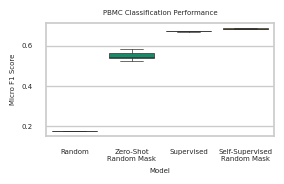

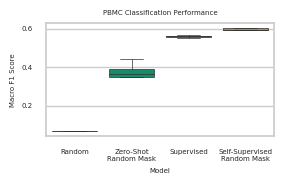

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your data processing code here...

# Step 1: Filter to include only 'new_run' entries
# df_new_run = df[df['Unnamed: 0'].str.contains('new_run')]

# Step 2: Rename model types
def rename_model(row):
    if 'PBMC_SSL' in row:
        return 'Self-Supervised\nRandom Mask'
    elif 'No SSL' in row:
        return 'Supervised'
    elif 'Only Pretrained' in row:
        return 'Zero-Shot\nRandom Mask'
    elif 'Random' in row:
        return 'Random'
    else:
        return row

df_new_run['Unnamed: 0'] = df_new_run['Unnamed: 0'].apply(rename_model)

model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Step 3: Calculate mean and std for each model
mean_std_df = df_new_run.groupby('Unnamed: 0')['f1-score: macro avg', 'f1-score: accuracy'].agg(['mean', 'std'])

# Step 4: Create box plots
sns.set_palette("colorblind")

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # This will be for titles and labels

# Start plotting
plt.figure(figsize=(3,2))
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: accuracy', data=df_new_run.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Micro F1 Score', fontdict=font)
ax.set_title('PBMC Classification Performance', fontdict=font)

# Set font for all tick labels to match the fontdict
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
plt.savefig(RESULT_PATH + "/classification/PBMC_Clf_Micro_F1.svg", bbox_inches='tight')  # Save as SVG

plt.tight_layout()
plt.show()

# Repeat for the second plot
plt.figure(figsize=(3, 2))
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: macro avg', data=df_new_run.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Macro F1 Score', fontdict=font)
ax.set_title('PBMC Classification Performance', fontdict=font)
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
plt.savefig(RESULT_PATH + "/classification/PBMC_Clf_Macro_F1.svg", bbox_inches='tight')  # Save as SVG

plt.tight_layout()
plt.show()


Histogram

In [101]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_per_class_report_pbmc_merged_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,F1_Self-Supervised,Cell Count,Cell Type,F1_Supervised
0,0,0.903427,154,B cell,0.779661
1,1,0.798301,555,"CD16-negative, CD56-bright natural killer cell...",0.829569
2,2,0.828407,5067,CD4-positive helper T cell,0.818499
3,3,0.507375,567,"CD4-positive, alpha-beta cytotoxic T cell",0.465072
4,4,0.787442,7122,"CD8-positive, alpha-beta cytotoxic T cell",0.765005
5,5,0.514677,2156,"central memory CD8-positive, alpha-beta T cell",0.499858
6,6,0.734072,323,class switched memory B cell,0.696532
7,7,0.974092,8950,classical monocyte,0.970662
8,8,0.733333,326,conventional dendritic cell,0.732348
9,9,0.750000,5,dendritic cell,0.727273


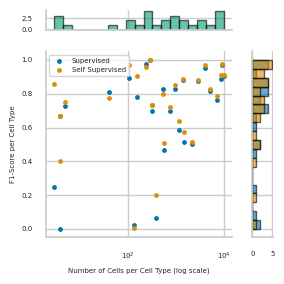

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use a colorblind-friendly palette
sns.set_palette("colorblind")
colors = sns.color_palette()

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # Adjust the size as needed

# Create a JointGrid with specified height
g = sns.JointGrid(x='Cell Count', y='F1_Supervised', data=df, height=3, marginal_ticks=True, space=0.2)
g = g.plot_joint(plt.scatter, s=6, color=colors[0], label="Supervised")  # Model A in one color
g.ax_joint.scatter(df['Cell Count'], df['F1_Self-Supervised'], s=6, color=colors[1], label="Self Supervised")  # Model B in another color

# Histograms
g.ax_marg_x.hist(df['Cell Count'], bins=np.geomspace(df['Cell Count'].min(), df['Cell Count'].max(), 20), alpha=.6, edgecolor='black', color=colors[2])
g.ax_marg_y.hist(df['F1_Supervised'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black', color=colors[0])
g.ax_marg_y.hist(df['F1_Self-Supervised'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black', color=colors[1])

# Labels & Title
g.set_axis_labels('Number of Cells per Cell Type (log scale)', 'F1-Score per Cell Type', **font)
g.ax_joint.set_xscale('log')

# Adjust legend with font properties
g.ax_joint.legend(prop=font)

# Apply font properties to all tick labels
for ax in [g.ax_joint, g.ax_marg_x, g.ax_marg_y]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(font['size'])
        label.set_family(font['family'])

# Save the plot
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/PBMC_per_celltype_perf.svg")
plt.show()


findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

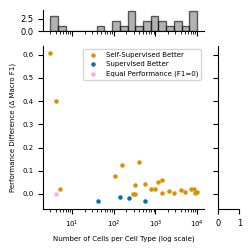

In [41]:
# Calculate the difference between F1 scores of Self-Supervised and Supervised
df['F1_Difference'] = df['F1_Self-Supervised'] - df['F1_Supervised']

# Filter the data for positive, negative, and equal non-zero F1_Difference
positive_diff = df[df['F1_Difference'] > 0]
negative_diff = df[df['F1_Difference'] < 0]
equal_non_zero_diff = df[(df['F1_Difference'] == 0)] # & (df['F1_Self-Supervised'] != 0) & (df['F1_Supervised'] != 0)]

# Create a JointGrid without the right histogram (deactivate marginal plots)
g = sns.JointGrid(x='Cell Count', y='F1_Difference', data=df, height=2.5, marginal_ticks=True, space=0.2)

# Plot the scatter points with color depending on the sign of the F1_Difference
# Points where Self-Supervised is better (positive difference)
g.ax_joint.scatter(positive_diff['Cell Count'], positive_diff['F1_Difference'], 
                   s=5, color=color_ssl, label="Self-Supervised Better")

# Points where Supervised is better (negative difference)
g.ax_joint.scatter(negative_diff['Cell Count'], negative_diff['F1_Difference'], 
                   s=5, color=color_supervised, label="Supervised Better")

# Points where performance is equal and non-zero
g.ax_joint.scatter(equal_non_zero_diff['Cell Count'], equal_non_zero_diff['F1_Difference'], 
                   s=5, color=color_else2, label="Equal Performance (F1=0)")

# Histogram on the top
g.ax_marg_x.hist(df['Cell Count'], bins=np.geomspace(df['Cell Count'].min(), df['Cell Count'].max(), 20), 
                 alpha=.6, edgecolor='black', color='grey')

# Labels & Title
g.set_axis_labels('Number of Cells per Cell Type (log scale)', 'Performance Difference (Δ Macro F1)', **font)
g.ax_joint.set_xscale('log')

# Adjust legend with font properties
g.ax_joint.legend(prop=font)

# Apply font properties to all tick labels
for label in g.ax_joint.get_xticklabels() + g.ax_joint.get_yticklabels():
    label.set_fontsize(font['size'])
    label.set_family(font['family'])

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/PBMC_Per_CT_Difference.svg", bbox_inches='tight')  # Save as SVG
plt.show()


Confusion Matrix

In [164]:
y_pred_supervised = np.load(os.path.join(RESULT_PATH, 'classification', 'new_predicted_labels_No_SSL_run2_PBMC_No SSL.npy'))
y_pred_ssl = np.load(os.path.join(RESULT_PATH, 'classification', 'new_predicted_labels_SSL_CN_MLP_50pnew_run2_PBMC_SSL.npy'))
y_true = np.load(os.path.join(RESULT_PATH, 'classification', 'new_true_labels_No_SSL_run2_PBMC_No SSL.npy'))  # same as for ssl, deterministic data loader


In [165]:
np.unique(y_pred_ssl)

array([  0,   6,   9,  11,  15,  45,  49,  50,  52,  54,  60,  61,  72,
        77,  80,  86, 109, 119, 122, 124, 125, 127, 131, 136, 137, 138,
       139, 145])

In [166]:
# Calculate correct predictions
correct_supervised = np.equal(y_pred_supervised, y_true).astype(int)
correct_ssl = np.equal(y_pred_ssl, y_true).astype(int)

# Calculate the sum of correct predictions for each class
unique_classes = np.unique(y_true)
correct_counts_supervised = [np.sum(correct_supervised[y_true == cls]) for cls in unique_classes]
correct_counts_ssl = [np.sum(correct_ssl[y_true == cls]) for cls in unique_classes]

# Calculate the differences
differences = np.array(correct_counts_ssl) - np.array(correct_counts_supervised)

In [167]:
cell_type_mapping = pd.read_parquet(
        os.path.join(DATA_PATH, "categorical_lookup/cell_type.parquet")
    )
cell_type_mapping['label'] = cell_type_mapping['label'].str.title()


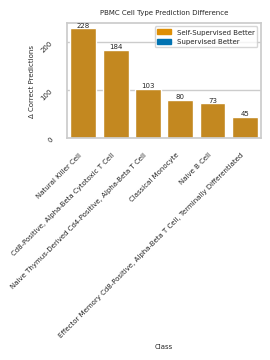

In [172]:
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Class': unique_classes,
    'Difference': differences
})

# Sort by absolute difference and select top n classes
n = 6  # Replace with your desired number of classes
df_plot['Absolute Difference'] = df_plot['Difference'].abs()
df_top_n = df_plot.sort_values(by='Absolute Difference', ascending=False).head(n)

# Assign colors based on the sign of the difference
df_top_n['Color'] = df_top_n['Difference'].apply(lambda x: color_ssl if x > 0 else color_supervised)

# Create a mapping dictionary from integer labels to string names
label_to_name_dict = cell_type_mapping['label'].to_dict()

# Replace integer class labels in df_top_n with string names
df_top_n['Class'] = df_top_n['Class'].map(label_to_name_dict)

# Plotting
bar_colors = [color_ssl, color_ssl, color_ssl, color_ssl, color_ssl, color_ssl]

plt.figure(figsize=(2.5, 1.5))
ax = sns.barplot(x='Class', y='Difference', data=df_top_n, palette=bar_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, **tick_font, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, **tick_font, ha='right')
ax.set_xlabel('Class', fontdict=font)
ax.set_ylabel('Δ Correct Predictions', fontdict=font)
ax.set_title('PBMC Cell Type Prediction Difference', fontdict=font)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=font['size'])
# Create legend handles
ssl_patch = mpatches.Patch(color=color_ssl, label='Self-Supervised Better')
supervised_patch = mpatches.Patch(color=color_supervised, label='Supervised Better')

# Add legend to the plot
ax.legend(handles=[ssl_patch, supervised_patch], loc='upper right', prop=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/pbmc_biggest_difference_barplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

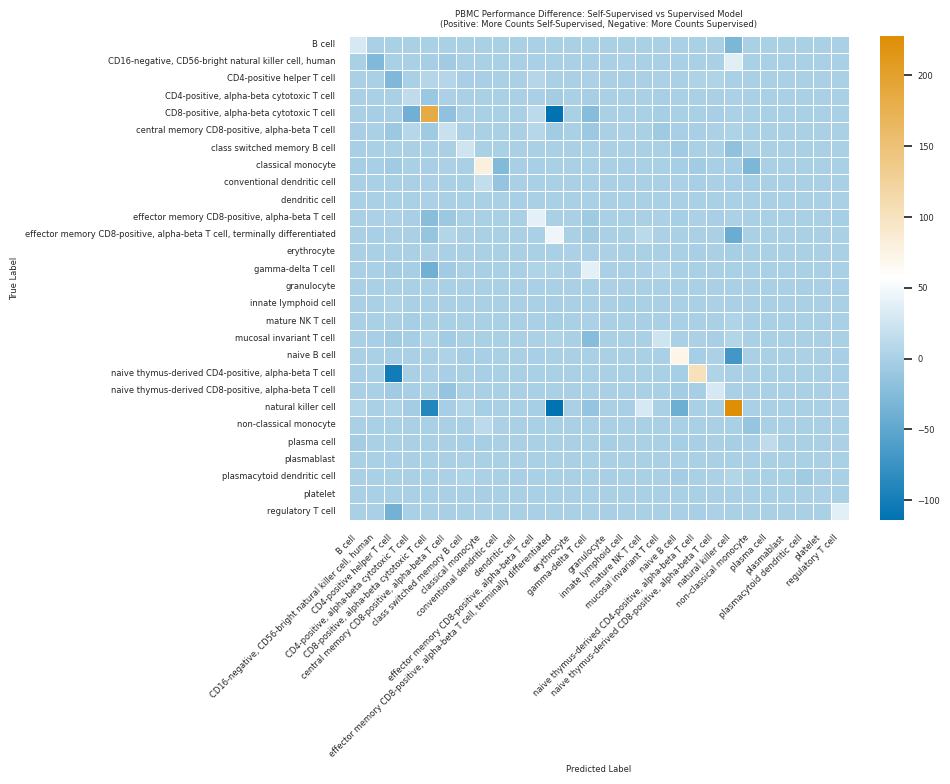

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# Compute the difference matrix
conf_matrix_difference = conf_matrix_ssl - conf_matrix_supervised

# Create a custom diverging colormap
top = mcolors.to_rgba(color_ssl)
bottom = mcolors.to_rgba(color_supervised)
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_map", [bottom, "white", top])

# Create heatmap without annotations for the difference matrix
plt.figure(figsize=(10, 8))  # Adjust figure size as needed for better visibility
ax = sns.heatmap(conf_matrix_difference, annot=False, cmap=custom_colormap, linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(conf_matrix_difference.columns, **tick_font, rotation=45, ha='right')
ax.set_yticklabels(conf_matrix_difference.index, **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('PBMC Performance Difference: Self-Supervised vs Supervised Model\n(Positive: More Counts Self-Supervised, Negative: More Counts Supervised)', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(6)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/pbmc_difference_confusion_matrix.svg", bbox_inches='tight')  # Save as SVG
plt.show()


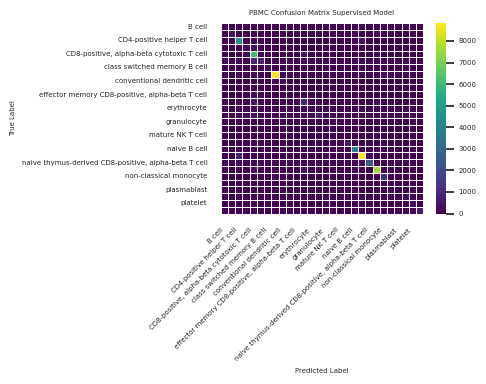

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'conf_matrix_supervised' is your DataFrame with the confusion matrix data

# Set the style for the plots
sns.set_theme()
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Create heatmap without annotations
plt.figure(figsize=(5, 4))  # Adjust figure size as needed
ax = sns.heatmap(conf_matrix_supervised, annot=False, cmap='viridis', linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(ax.get_xticklabels(), **tick_font, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('PBMC Confusion Matrix Supervised Model', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(5)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/confusion_matrix_pbmc_supervised.svg", bbox_inches='tight')  # Save as SVG
plt.show()


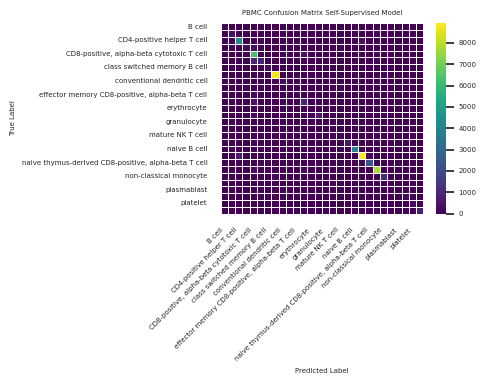

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'conf_matrix_supervised' is your DataFrame with the confusion matrix data

# Set the style for the plots
sns.set_theme()
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Create heatmap without annotations
plt.figure(figsize=(5, 4))  # Adjust figure size as needed
ax = sns.heatmap(conf_matrix_ssl, annot=False, cmap='viridis', linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(ax.get_xticklabels(), **tick_font, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('PBMC Confusion Matrix Self-Supervised Model', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(5)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/confusion_matrix_pbmc_ssl.svg", bbox_inches='tight')  # Save as SVG
plt.show()


### 3. Tabula Sapiens

In [72]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_tabula_sapiens_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.378728,0.316118,0.394623,0.378728,0.256949,0.378728,0.378728,0.242161,0.343792,0.378728,189756.0,189756.0
3,CN_MLP_50prun1_Only Pretrained,0.333734,0.319648,0.451201,0.333734,0.250871,0.333734,0.333734,0.227661,0.299159,0.333734,189756.0,189756.0
6,CN_MLP_50prun2_Only Pretrained,0.415839,0.339496,0.473854,0.415839,0.287561,0.415839,0.415839,0.267901,0.373793,0.415839,189756.0,189756.0
9,CN_MLP_50prun3_Only Pretrained,0.366523,0.321953,0.401659,0.366523,0.260692,0.366523,0.366523,0.246669,0.343192,0.366523,189756.0,189756.0
12,CN_MLP_50prun4_Only Pretrained,0.372547,0.321937,0.459513,0.372547,0.265323,0.372547,0.372547,0.252573,0.342679,0.372547,189756.0,189756.0
15,No_SSL_new_run0_Tabula_Sapiens_No SSL,0.450247,0.313316,0.436672,0.450247,0.286250,0.450247,0.450247,0.266878,0.403000,0.450247,189756.0,189756.0
465,No_SSL_new_run1_Tabula_Sapiens_No SSL,0.464649,0.318175,0.434159,0.464649,0.304493,0.464649,0.464649,0.284214,0.415446,0.464649,189756.0,189756.0
555,No_SSL_new_run2_Tabula_Sapiens_No SSL,0.449135,0.314254,0.439427,0.449135,0.280712,0.449135,0.449135,0.253358,0.401351,0.449135,189756.0,189756.0
645,No_SSL_new_run3_Tabula_Sapiens_No SSL,0.461514,0.318479,0.445367,0.461514,0.287370,0.461514,0.461514,0.269275,0.414177,0.461514,189756.0,189756.0
735,No_SSL_new_run4_Tabula_Sapiens_No SSL,0.465972,0.329670,0.447619,0.465972,0.306503,0.465972,0.465972,0.287162,0.419952,0.465972,189756.0,189756.0


In [73]:
models_to_select = ['CN_MLP_50p_Only Pretrained', 
                    'CN_MLP_50prun1_Only Pretrained', 
                    'CN_MLP_50prun2_Only Pretrained', 
                    'CN_MLP_50prun3_Only Pretrained', 
                    'CN_MLP_50prun4_Only Pretrained', 
                    'No_SSL_new_run0_Tabula_Sapiens_No SSL',
                    'No_SSL_new_run1_Tabula_Sapiens_No SSL',
                    'No_SSL_new_run2_Tabula_Sapiens_No SSL',
                    'No_SSL_new_run3_Tabula_Sapiens_No SSL',
                    'No_SSL_new_run4_Tabula_Sapiens_No SSL',
                    'Random',
                    'SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL',
                    'SSL_CN_MLP_50pnew_run1_Tabula_Sapiens_SSL',
                    'SSL_CN_MLP_50pnew_run2_Tabula_Sapiens_SSL',
                    'SSL_CN_MLP_50pnew_run3_Tabula_Sapiens_SSL',
                    'SSL_CN_MLP_50pnew_run4_Tabula_Sapiens_SSL',
                   ]

df_new_run = df[df['Unnamed: 0'].isin(models_to_select)]
df_new_run

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,CN_MLP_50p_Only Pretrained,0.378728,0.316118,0.394623,0.378728,0.256949,0.378728,0.378728,0.242161,0.343792,0.378728,189756.0,189756.0
3,CN_MLP_50prun1_Only Pretrained,0.333734,0.319648,0.451201,0.333734,0.250871,0.333734,0.333734,0.227661,0.299159,0.333734,189756.0,189756.0
6,CN_MLP_50prun2_Only Pretrained,0.415839,0.339496,0.473854,0.415839,0.287561,0.415839,0.415839,0.267901,0.373793,0.415839,189756.0,189756.0
9,CN_MLP_50prun3_Only Pretrained,0.366523,0.321953,0.401659,0.366523,0.260692,0.366523,0.366523,0.246669,0.343192,0.366523,189756.0,189756.0
12,CN_MLP_50prun4_Only Pretrained,0.372547,0.321937,0.459513,0.372547,0.265323,0.372547,0.372547,0.252573,0.342679,0.372547,189756.0,189756.0
15,No_SSL_new_run0_Tabula_Sapiens_No SSL,0.450247,0.313316,0.436672,0.450247,0.286250,0.450247,0.450247,0.266878,0.403000,0.450247,189756.0,189756.0
465,No_SSL_new_run1_Tabula_Sapiens_No SSL,0.464649,0.318175,0.434159,0.464649,0.304493,0.464649,0.464649,0.284214,0.415446,0.464649,189756.0,189756.0
555,No_SSL_new_run2_Tabula_Sapiens_No SSL,0.449135,0.314254,0.439427,0.449135,0.280712,0.449135,0.449135,0.253358,0.401351,0.449135,189756.0,189756.0
645,No_SSL_new_run3_Tabula_Sapiens_No SSL,0.461514,0.318479,0.445367,0.461514,0.287370,0.461514,0.461514,0.269275,0.414177,0.461514,189756.0,189756.0
735,No_SSL_new_run4_Tabula_Sapiens_No SSL,0.465972,0.329670,0.447619,0.465972,0.306503,0.465972,0.465972,0.287162,0.419952,0.465972,189756.0,189756.0


In [76]:
np.mean((0.378728, 0.333734, 0.415839, 0.366523, 0.372547))

0.3734742

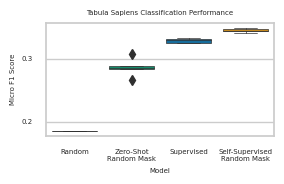

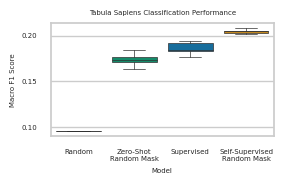

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your data processing code here...

# Step 1: Filter to include only 'new_run' entries
# df_new_run = df[df['Unnamed: 0'].str.contains('new_run')]

# Step 2: Rename model types
def rename_model(row):
    if 'SSL_CN' in row:
        return 'Self-Supervised\nRandom Mask'
    elif 'No SSL' in row:
        return 'Supervised'
    elif 'Only Pretrained' in row:
        return 'Zero-Shot\nRandom Mask'
    elif 'Random' in row:
        return 'Random'
    else:
        return row

df_new_run['Unnamed: 0'] = df_new_run['Unnamed: 0'].apply(rename_model)

model_colors = [color_baseline, color_zeroshot, color_supervised, color_ssl]

# Step 3: Calculate mean and std for each model
mean_std_df = df_new_run.groupby('Unnamed: 0')['f1-score: macro avg', 'f1-score: accuracy'].agg(['mean', 'std'])

# Step 4: Create box plots
sns.set_palette("colorblind")

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # This will be for titles and labels

# Start plotting
plt.figure(figsize=(3,2))
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: accuracy', data=df_new_run.sort_values('f1-score: accuracy'), linewidth=0.5, palette=model_colors)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Micro F1 Score', fontdict=font)
ax.set_title('Tabula Sapiens Classification Performance', fontdict=font)

# Set font for all tick labels to match the fontdict
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
plt.savefig(RESULT_PATH + "/classification/Tabula_Sapiens_Clf_Micro_F1.svg", bbox_inches='tight')  # Save as SVG

plt.tight_layout()
plt.show()

# Repeat for the second plot
plt.figure(figsize=(3, 2))
ax = sns.boxplot(x='Unnamed: 0', y='f1-score: macro avg', data=df_new_run.sort_values('f1-score: macro avg'), linewidth=0.5, palette=model_colors)
ax.set_xlabel('Model', fontdict=font)
ax.set_ylabel('Macro F1 Score', fontdict=font)
ax.set_title('Tabula Sapiens Classification Performance', fontdict=font)
ax.set_xticklabels(ax.get_xticklabels(), **tick_font)
ax.set_yticklabels(ax.get_yticklabels(), **tick_font)
plt.savefig(RESULT_PATH + "/classification/Tabula_Sapiens_Clf_Macro_F1.svg", bbox_inches='tight')  # Save as SVG

plt.tight_layout()
plt.show()


Histogram

In [105]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_per_class_report_tabula_sapiens_merged_knn.csv')
df = pd.read_csv(file_path, index_col=0)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

,F1_Self-Supervised,Cell Count,Cell Type,F1_Supervised
0,0.749235,11338,B cell,0.770377
1,0.000000,95,CD1c-positive myeloid dendritic cell,0.000000
2,0.000000,7784,CD4-positive helper T cell,0.000000
3,0.191676,11008,"CD4-positive, alpha-beta T cell",0.179736
4,0.000000,2866,"CD4-positive, alpha-beta memory T cell",0.000000
5,0.171794,8505,"CD8-positive, alpha-beta T cell",0.182651
6,0.000000,543,"CD8-positive, alpha-beta cytotoxic T cell",0.000000
7,0.000000,4408,"CD8-positive, alpha-beta memory T cell",0.000000
8,0.000000,10,Schwann cell,0.000000
9,0.327161,7486,T cell,0.334209


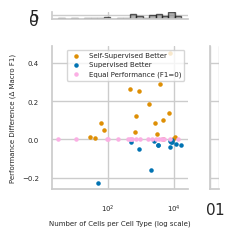

In [106]:
# Calculate the difference between F1 scores of Self-Supervised and Supervised
df['F1_Difference'] = df['F1_Self-Supervised'] - df['F1_Supervised']

# Filter the data for positive, negative, and equal non-zero F1_Difference
positive_diff = df[df['F1_Difference'] > 0]
negative_diff = df[df['F1_Difference'] < 0]
equal_non_zero_diff = df[(df['F1_Difference'] == 0)] # & (df['F1_Self-Supervised'] != 0) & (df['F1_Supervised'] != 0)]

# Create a JointGrid without the right histogram (deactivate marginal plots)
g = sns.JointGrid(x='Cell Count', y='F1_Difference', data=df, height=2.5, marginal_ticks=True, space=0.2)

# Plot the scatter points with color depending on the sign of the F1_Difference
# Points where Self-Supervised is better (positive difference)
g.ax_joint.scatter(positive_diff['Cell Count'], positive_diff['F1_Difference'], 
                   s=5, color=color_ssl, label="Self-Supervised Better")

# Points where Supervised is better (negative difference)
g.ax_joint.scatter(negative_diff['Cell Count'], negative_diff['F1_Difference'], 
                   s=5, color=color_supervised, label="Supervised Better")

# Points where performance is equal and non-zero
g.ax_joint.scatter(equal_non_zero_diff['Cell Count'], equal_non_zero_diff['F1_Difference'], 
                   s=5, color=color_else2, label="Equal Performance (F1=0)")

# Histogram on the top
g.ax_marg_x.hist(df['Cell Count'], bins=np.geomspace(df['Cell Count'].min(), df['Cell Count'].max(), 20), 
                 alpha=.6, edgecolor='black', color='grey')

# Labels & Title
g.set_axis_labels('Number of Cells per Cell Type (log scale)', 'Performance Difference (Δ Macro F1)', **font)
g.ax_joint.set_xscale('log')

# Adjust legend with font properties
g.ax_joint.legend(prop=font)

# Apply font properties to all tick labels
for label in g.ax_joint.get_xticklabels() + g.ax_joint.get_yticklabels():
    label.set_fontsize(font['size'])
    label.set_family(font['family'])

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/Tabula_Sapiens_Per_CT_Difference.svg", bbox_inches='tight')  # Save as SVG
plt.show()


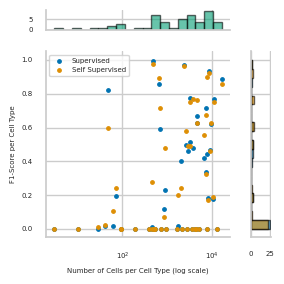

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use a colorblind-friendly palette
sns.set_palette("colorblind")
colors = sns.color_palette()

# Define font properties
font = {'family': 'sans-serif', 'size': 5}  # Adjust the size as needed

# Create a JointGrid with specified height
g = sns.JointGrid(x='Cell Count', y='F1_Supervised', data=df, height=3, marginal_ticks=True, space=0.2)
g = g.plot_joint(plt.scatter, s=6, color=colors[0], label="Supervised")  # Model A in one color
g.ax_joint.scatter(df['Cell Count'], df['F1_Self-Supervised'], s=6, color=colors[1], label="Self Supervised")  # Model B in another color

# Histograms
g.ax_marg_x.hist(df['Cell Count'], bins=np.geomspace(df['Cell Count'].min(), df['Cell Count'].max(), 20), alpha=.6, edgecolor='black', color=colors[2])
g.ax_marg_y.hist(df['F1_Supervised'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black', color=colors[0])
g.ax_marg_y.hist(df['F1_Self-Supervised'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black', color=colors[1])

# Labels & Title
g.set_axis_labels('Number of Cells per Cell Type (log scale)', 'F1-Score per Cell Type', **font)
g.ax_joint.set_xscale('log')

# Adjust legend with font properties
g.ax_joint.legend(prop=font)

# Apply font properties to all tick labels
for ax in [g.ax_joint, g.ax_marg_x, g.ax_marg_y]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(font['size'])
        label.set_family(font['family'])

# Save the plot
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/Tabula_Sapiens_per_celltype_perf.svg")
plt.show()


Confusion Matrix

In [156]:
y_pred_supervised = np.load(os.path.join(RESULT_PATH, 'classification', 'new_predicted_labels_No_SSL_new_run4_Tabula_Sapiens_No SSL.npy'))
y_pred_ssl = np.load(os.path.join(RESULT_PATH, 'classification', 'new_predicted_labels_SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL.npy'))
y_true = np.load(os.path.join(RESULT_PATH, 'classification', 'new_true_labels_No_SSL_new_run4_Tabula_Sapiens_No SSL.npy'))  # same as for ssl, deterministic data loader


In [157]:
np.unique(y_pred_ssl)

array([  0,  10,  14,  22,  36,  38,  40,  50,  51,  54,  63,  64,  65,
        72,  82, 100, 101, 106, 107, 109, 114, 116, 118, 122, 131, 135,
       136, 137, 138, 153, 159, 160, 161, 162])

In [158]:
# Calculate correct predictions
correct_supervised = np.equal(y_pred_supervised, y_true).astype(int)
correct_ssl = np.equal(y_pred_ssl, y_true).astype(int)

# Calculate the sum of correct predictions for each class
unique_classes = np.unique(y_true)
correct_counts_supervised = [np.sum(correct_supervised[y_true == cls]) for cls in unique_classes]
correct_counts_ssl = [np.sum(correct_ssl[y_true == cls]) for cls in unique_classes]

# Calculate the differences
differences = np.array(correct_counts_ssl) - np.array(correct_counts_supervised)

In [159]:
cell_type_mapping = pd.read_parquet(
        os.path.join(DATA_PATH, "categorical_lookup/cell_type.parquet")
    )
cell_type_mapping['label'] = cell_type_mapping['label'].str.title()


In [160]:
(y_true == 160).sum()

7717

In [161]:
correct_pneumocyte_supervised = [np.sum(correct_supervised[y_true == cls]) for cls in [160]]
correct_pneumocyte_supervised

[2441]

In [162]:
correct_pneumocyte_ssl = [np.sum(correct_ssl[y_true == cls]) for cls in [160]]
correct_pneumocyte_ssl

[6881]

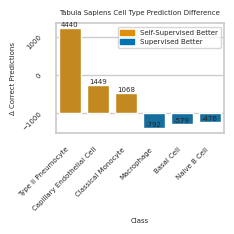

In [163]:
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Class': unique_classes,
    'Difference': differences
})

# Sort by absolute difference and select top n classes
n = 6  # Replace with your desired number of classes
df_plot['Absolute Difference'] = df_plot['Difference'].abs()
df_top_n = df_plot.sort_values(by='Absolute Difference', ascending=False).head(n)

# Assign colors based on the sign of the difference
df_top_n['Color'] = df_top_n['Difference'].apply(lambda x: color_ssl if x > 0 else color_supervised)

# Create a mapping dictionary from integer labels to string names
label_to_name_dict = cell_type_mapping['label'].to_dict()

# Replace integer class labels in df_top_n with string names
df_top_n['Class'] = df_top_n['Class'].map(label_to_name_dict)

# Plotting
bar_colors = [color_ssl, color_ssl, color_ssl, color_supervised, color_supervised, color_supervised]

plt.figure(figsize=(2.5, 2.5))
ax = sns.barplot(x='Class', y='Difference', data=df_top_n, palette=bar_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, **tick_font, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, **tick_font, ha='right')
ax.set_xlabel('Class', fontdict=font)
ax.set_ylabel('Δ Correct Predictions', fontdict=font)
ax.set_title('Tabula Sapiens Cell Type Prediction Difference', fontdict=font)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=font['size'])
# Create legend handles
ssl_patch = mpatches.Patch(color=color_ssl, label='Self-Supervised Better')
supervised_patch = mpatches.Patch(color=color_supervised, label='Supervised Better')

# Add legend to the plot
ax.legend(handles=[ssl_patch, supervised_patch], loc='upper right', prop=font)
plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/tabula_sapiens_biggest_difference_barplot.svg", bbox_inches='tight')  # Save as SVG
plt.show()

In [8]:
true_counts_supervised = pd.read_csv(os.path.join(RESULT_PATH, 'classification', 'correct_counts_No_SSL_new_run4_Tabula_Sapiens_No SSL.csv'), index_col='Unnamed: 0')
true_counts_ssl = pd.read_csv(os.path.join(RESULT_PATH, 'classification', 'correct_counts_SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL.csv'), index_col='Unnamed: 0')
true_counts = pd.read_csv(os.path.join(RESULT_PATH, 'classification', 'Tabula_Sapiens_true_counts.csv'), index_col='Unnamed: 0')

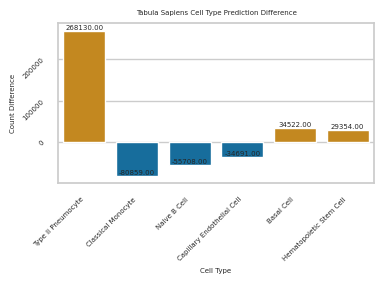

In [9]:
# Ensure cell type names are capitalized
true_counts_ssl['Cell Type'] = true_counts_ssl.index.str.title()
true_counts_supervised['Cell Type'] = true_counts_supervised.index.str.title()

# Merge the dataframes on cell type
df_merged = pd.merge(true_counts_ssl, true_counts_supervised, on='Cell Type', suffixes=('_self', '_supervised'))

# Calculate the difference in counts
df_merged['Count Difference'] = df_merged['Correct Count_self'] - df_merged['Correct Count_supervised']

# Select n cell types with the largest absolute differences
n = 6 # You can adjust this number
df_subset = df_merged.reindex(df_merged['Count Difference'].abs().nlargest(n).index)

# Assign colors based on whether the self-supervised model is better or not
df_subset['Color'] = df_subset['Count Difference'].apply(lambda x: color_ssl if x > 0 else color_supervised)

# Plotting
plt.figure(figsize=(4, 3))
ax = sns.barplot(x='Cell Type', y='Count Difference', data=df_subset, palette=df_subset['Color'].tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, **tick_font, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, **tick_font, ha='right')
ax.set_xlabel('Cell Type', fontdict=font)
ax.set_ylabel('Count Difference', fontdict=font)
ax.set_title('Tabula Sapiens Cell Type Prediction Difference', fontdict=font)

# Annotate bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=font['size'])

plt.tight_layout()
plt.show()

In [11]:
true_counts_ssl

,Correct Count,Cell Type
B cell,30504.0,B Cell
CD1c-positive myeloid dendritic cell,8248.0,Cd1C-Positive Myeloid Dendritic Cell
CD4-positive helper T cell,118531.0,Cd4-Positive Helper T Cell
"CD4-positive, alpha-beta T cell",226009.0,"Cd4-Positive, Alpha-Beta T Cell"
"CD4-positive, alpha-beta memory T cell",50842.0,"Cd4-Positive, Alpha-Beta Memory T Cell"
"CD8-positive, alpha-beta T cell",253215.0,"Cd8-Positive, Alpha-Beta T Cell"
"CD8-positive, alpha-beta cytotoxic T cell",9694.0,"Cd8-Positive, Alpha-Beta Cytotoxic T Cell"
"CD8-positive, alpha-beta memory T cell",81787.0,"Cd8-Positive, Alpha-Beta Memory T Cell"
Schwann cell,852.0,Schwann Cell
T cell,173135.0,T Cell


In [10]:
true_counts

,True Count
B cell,11338.0
CD1c-positive myeloid dendritic cell,95.0
CD4-positive helper T cell,7784.0
"CD4-positive, alpha-beta T cell",11008.0
"CD4-positive, alpha-beta memory T cell",2866.0
"CD8-positive, alpha-beta T cell",8505.0
"CD8-positive, alpha-beta cytotoxic T cell",543.0
"CD8-positive, alpha-beta memory T cell",4408.0
Schwann cell,10.0
T cell,7486.0


In [8]:
conf_matrix_supervised = pd.read_csv(os.path.join(RESULT_PATH, 'classification', 'conf_matrix_No_SSL_new_run4_Tabula_Sapiens_No SSL.csv'), index_col='Unnamed: 0')
conf_matrix_ssl = pd.read_csv(os.path.join(RESULT_PATH, 'classification', 'conf_matrix_SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL.csv'), index_col='Unnamed: 0')

In [12]:
# Summing up the columns for each confusion matrix
sum_per_class_1 = conf_matrix_supervised.sum(axis=0)
sum_per_class_2 = conf_matrix_ssl.sum(axis=0)

# Display the sums
print("Sum per class for the first model:\n", sum_per_class_1)
print("\nSum per class for the second model:\n", sum_per_class_2)

Sum per class for the first model:
 B cell                                    16383
CD4-positive, alpha-beta T cell            2833
CD8-positive, alpha-beta T cell            2573
T cell                                    23193
basal cell                                 6373
blood vessel endothelial cell                33
capillary endothelial cell                 1919
classical monocyte                         2966
club cell                                    91
dendritic cell                               99
endothelial cell                           8296
endothelial cell of artery                  558
endothelial cell of lymphatic vessel        752
erythrocyte                                2325
hematopoietic stem cell                       3
leukocyte                                   499
macrophage                                16914
mast cell                                   720
mature NK T cell                           3582
memory B cell                              4697
meso

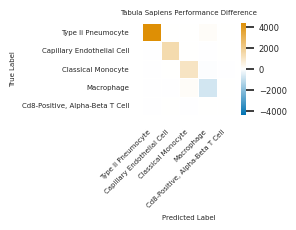

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# Compute the difference matrix
conf_matrix_difference = conf_matrix_ssl - conf_matrix_supervised

# Identify the top N cell types with the largest absolute differences
N = 5  # Number of top differences to display
top_differences = conf_matrix_difference.abs().sum(axis=1).nlargest(N).index

# Create a subset DataFrame for these top differences
conf_matrix_subset = conf_matrix_difference.loc[top_differences, top_differences]

# Capitalize the first letter of each word in the columns
conf_matrix_subset.columns = conf_matrix_subset.columns.str.title()

# Capitalize the first letter of each word in the index
conf_matrix_subset.index = conf_matrix_subset.index.str.title()

# Create a custom diverging colormap
top = mcolors.to_rgba(color_ssl)
bottom = mcolors.to_rgba(color_supervised)
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_map", [bottom, "white", top])

# Define the range for the colormap
max_abs_value = np.abs(conf_matrix_subset.values).max()
vmin, vmax = -max_abs_value, max_abs_value

# Create heatmap without annotations for the subset difference matrix
plt.figure(figsize=(1.5, 1.2))  # Adjust figure size as needed for better visibility
ax = sns.heatmap(conf_matrix_subset, annot=False, cmap=custom_colormap, linewidths=.5, vmin=vmin, vmax=vmax)

# Set the font for the tick labels
ax.set_xticklabels(conf_matrix_subset.columns, **tick_font, rotation=45, ha='right')
ax.set_yticklabels(conf_matrix_subset.index, **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('Tabula Sapiens Performance Difference', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(6)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/tabula_sapiens_biggest_difference_confusion_matrix.svg", bbox_inches='tight')  # Save as SVG
plt.show()


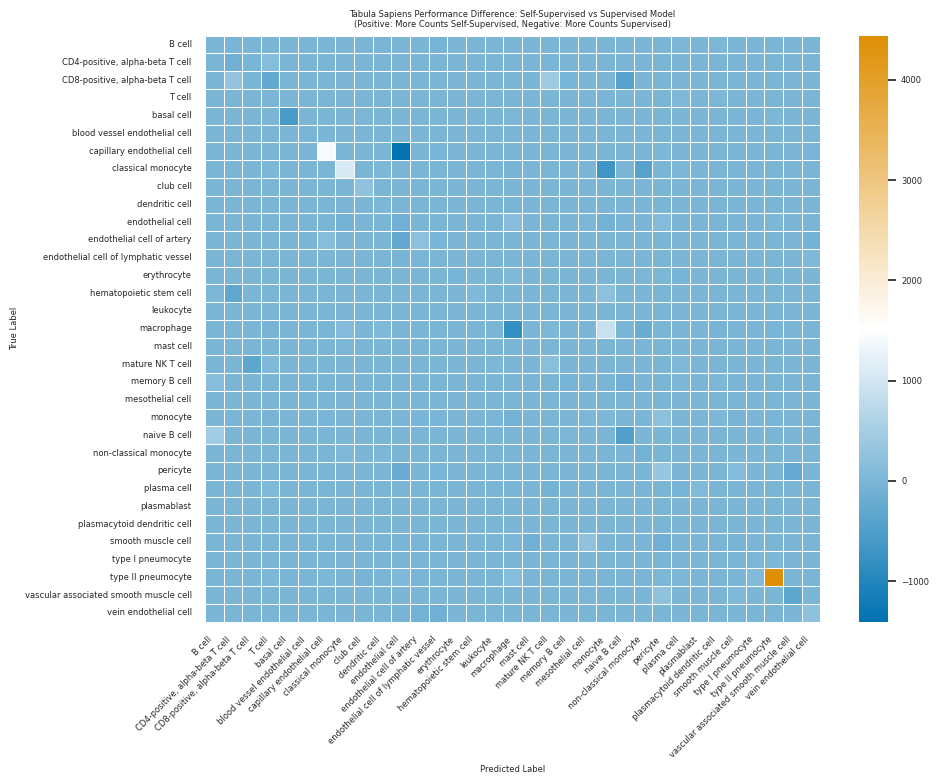

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# Compute the difference matrix
conf_matrix_difference = conf_matrix_ssl - conf_matrix_supervised

# Create a custom diverging colormap
top = mcolors.to_rgba(color_ssl)
bottom = mcolors.to_rgba(color_supervised)
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_map", [bottom, "white", top])

# Create heatmap without annotations for the difference matrix
plt.figure(figsize=(10, 8))  # Adjust figure size as needed for better visibility
ax = sns.heatmap(conf_matrix_difference, annot=False, cmap=custom_colormap, linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(conf_matrix_difference.columns, **tick_font, rotation=45, ha='right')
ax.set_yticklabels(conf_matrix_difference.index, **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('Tabula Sapiens Performance Difference: Self-Supervised vs Supervised Model\n(Positive: More Counts Self-Supervised, Negative: More Counts Supervised)', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(6)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/tabula_sapiens_difference_confusion_matrix.svg", bbox_inches='tight')  # Save as SVG
plt.show()


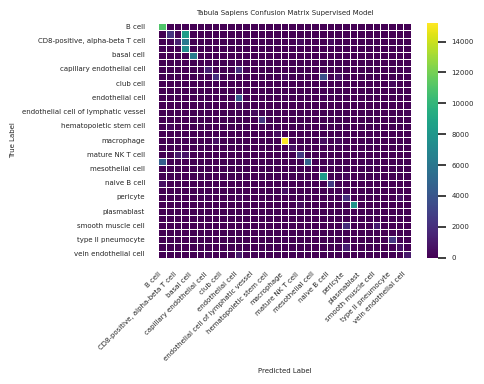

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'conf_matrix_supervised' is your DataFrame with the confusion matrix data

# Set the style for the plots
sns.set_theme()
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Create heatmap without annotations
plt.figure(figsize=(5, 4))  # Adjust figure size as needed
ax = sns.heatmap(conf_matrix_supervised, annot=False, cmap='viridis', linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(ax.get_xticklabels(), **tick_font, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('Tabula Sapiens Confusion Matrix Supervised Model', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(5)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/confusion_matrix_tabula_sapiens_supervised.svg", bbox_inches='tight')  # Save as SVG
plt.show()


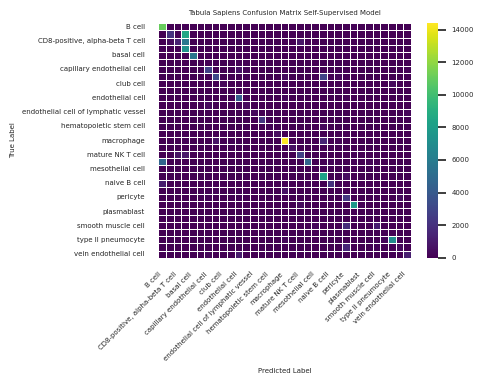

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'conf_matrix_supervised' is your DataFrame with the confusion matrix data

# Set the style for the plots
sns.set_theme()
sns.set_palette("colorblind")

# Define font properties for titles and labels
font = {'family': 'sans-serif', 'size': 5}  # Adjust size as needed
tick_font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Adjust font size for tick labels

# Create heatmap without annotations
plt.figure(figsize=(5, 4))  # Adjust figure size as needed
ax = sns.heatmap(conf_matrix_ssl, annot=False, cmap='viridis', linewidths=.5)

# Set the font for the tick labels
ax.set_xticklabels(ax.get_xticklabels(), **tick_font, rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), **tick_font, rotation=0)

# Set the font for the axis labels and title
ax.set_xlabel('Predicted Label', fontdict=font)
ax.set_ylabel('True Label', fontdict=font)
ax.set_title('Tabula Sapiens Confusion Matrix Self-Supervised Model', fontdict=font)

# Adjust the font for the numbers on the heatbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)  # Adjust font size for color bar

# Change font for the color bar tick labels
for label in cbar.ax.get_yticklabels():
    label.set_fontname('sans-serif')
    label.set_fontsize(5)

plt.tight_layout()
plt.savefig(RESULT_PATH + "/classification/confusion_matrix_tabula_sapiens_ssl.svg", bbox_inches='tight')  # Save as SVG
plt.show()


# Figure 4 - effect of HVGs

In [ ]:
model_dirs = [
    
    # 2000 HVGs
    ### Supervised Models ###
    
    MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',

    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/final_models/classification/SSL_HVG_2000_CN_HVG_2000_MLP_50prun0/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    
    # Full Transcriptome
    ### Supervised Models ###
    MODEL_PATH + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
]

In [ ]:
eval_emb_knn_hvgs(model_dirs)